<a href="https://colab.research.google.com/github/jiin-son/credit_card_fraud_detection/blob/main/NBA_Machine_Learning_(xgboost).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.3f}'.format

In [2]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score

In [3]:
!pip install xgboost
import xgboost as xgb

In [4]:
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 9.0 MB/s eta 0:00:00


In [10]:
from google.colab import files
uploaded = files.upload()

Saving all_teams_gamelog_df.csv to all_teams_gamelog_df.csv


In [6]:
final_df = pd.read_csv('final_df.csv')

In [7]:
# Function to convert time to total minutes
def time_to_minutes(time_str):
    try:
        minutes, seconds = time_str.split(':')
        minutes = float(minutes)  # Handle decimal minutes
        seconds = int(seconds)  # Handle seconds
        return minutes + seconds / 60
    except ValueError:
        return None  # Handle invalid formats gracefully

# Apply the function
final_df['TOTAL_MIN'] = final_df['MIN'].apply(time_to_minutes)

In [8]:
# remove records that MIN is less than 1 minute
final_df = final_df[final_df['TOTAL_MIN'] >= 1]

In [9]:
final_df

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,POSITION,HEIGHT,WEIGHT,YEARS_IN_LEAGUE,GAME_DATE,GAME_MIN,W,HOME,OVERTIME,REST_DAYS,MIN_LAST_SEASON,FGM_LAST_SEASON,FGA_LAST_SEASON,FG_PCT_LAST_SEASON,FG3M_LAST_SEASON,FG3A_LAST_SEASON,FG3_PCT_LAST_SEASON,FTM_LAST_SEASON,FTA_LAST_SEASON,FT_PCT_LAST_SEASON,OREB_LAST_SEASON,DREB_LAST_SEASON,REB_LAST_SEASON,AST_LAST_SEASON,STL_LAST_SEASON,BLK_LAST_SEASON,TOV_LAST_SEASON,PF_LAST_SEASON,PTS_LAST_SEASON,TRADED_LAST_SEASON,PLAYER_AGE,TRADED_THIS_SEASON,Height_in_Inches,POS_G,POS_F,POS_C,POS_FC,POS_GF,POS_CF,POS_FG,START_POS_F,START_POS_G,START_POS_C,TEAM_GSW,TEAM_OKC,TEAM_CHI,TEAM_MEM,TEAM_ORL,TEAM_SAS,TEAM_DAL,TEAM_TOR,TEAM_LAC,TEAM_PHI,TEAM_SAC,TEAM_BOS,TEAM_IND,TEAM_DET,TEAM_MIL,TEAM_CLE,TEAM_WAS,TEAM_CHA,TEAM_HOU,TEAM_DEN,TEAM_PHX,TEAM_MIA,TEAM_UTA,TEAM_LAL,TEAM_POR,TEAM_MIN,TEAM_NYK,TEAM_BKN,TEAM_ATL,TEAM_NOP,TOTAL_MIN
0,22400487,1610612738,BOS,Boston,1627759,Jaylen Brown,Jaylen,F,NaN,39.000000:37,8.000,19.000,0.421,1.000,6.000,0.167,4.000,4.000,1.000,0.000,3.000,3.000,3.000,1.000,1.000,3.000,2.000,21.000,-7.000,Guard-Forward,6-6,223.000,9.000,2025-01-05,240.000,0.000,0.000,0.000,2.000,2343.000,627.000,1256.000,0.499,145.000,410.000,0.354,211.000,300.000,0.703,84.000,303.000,387.000,249.000,83.000,37.000,166.000,185.000,1610.000,0.000,28.000,0,78,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39.617
1,22400487,1610612738,BOS,Boston,1628369,Jayson Tatum,Jayson,F,NaN,38.000000:52,7.000,17.000,0.412,2.000,6.000,0.333,10.000,12.000,0.833,1.000,9.000,10.000,1.000,2.000,0.000,2.000,1.000,26.000,-12.000,Forward-Guard,6-8,210.000,8.000,2025-01-05,240.000,0.000,0.000,0.000,2.000,2645.000,672.000,1426.000,0.471,229.000,609.000,0.376,414.000,497.000,0.833,67.000,534.000,601.000,364.000,75.000,43.000,188.000,145.000,1987.000,0.000,26.000,0,80,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38.867
2,22400487,1610612738,BOS,Boston,204001,Kristaps Porziņģis,Kristaps,C,NaN,29.000000:19,6.000,12.000,0.500,1.000,6.000,0.167,6.000,6.000,1.000,4.000,5.000,9.000,1.000,1.000,0.000,4.000,5.000,19.000,-17.000,Forward-Center,7-2,240.000,10.000,2025-01-05,240.000,0.000,0.000,0.000,2.000,1690.000,388.000,752.000,0.516,110.000,293.000,0.375,259.000,302.000,0.858,97.000,312.000,409.000,115.000,42.000,111.000,89.000,156.000,1145.000,0.000,29.000,0,86,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29.317
3,22400487,1610612738,BOS,Boston,1628401,Derrick White,Derrick,G,NaN,37.000000:16,4.000,13.000,0.308,2.000,11.000,0.182,1.000,2.000,0.500,0.000,4.000,4.000,4.000,1.000,3.000,3.000,1.000,11.000,-8.000,Guard,6-4,190.000,8.000,2025-01-05,240.000,0.000,0.000,0.000,2.000,2381.000,387.000,839.000,0.461,196.000,495.000,0.396,137.000,152.000,0.901,51.000,259.000,310.000,377.000,74.000,87.000,112.000,152.000,1107.000,0.000,30.000,0,76,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.267
4,22400487,1610612738,BOS,Boston,201950,Jrue Holiday,Jrue,G,NaN,33.000000:49,1.000,6.000,0.167,0.000,4.000,0.000,0.000,0.000,0.000,3.000,5.000,8.000,6.000,0.000,0.000,2.000,4.000,2.000,-11.000,Guard,6-4,205.000,16.000,2025-01-05,240.000,0.000,0.000,0.000,2.000,2263.000,331.000,689.000,0.480,138.000,322.000,0.429,60.000,72.000,0.833,84.000,289.000,373.000,333.000,61.000,53.000,124.000,108.000,860.000,0.000,34.000,0,76,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33.817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [11]:
teams_gamelog_df = pd.read_csv('all_teams_gamelog_df.csv')

In [12]:
# prompt: create a column that shows win streak for the previous  GAME_DATE (one game lag) for each Team_ID and Game_ID

# Sort the DataFrame by Team_ID and GAME_DATE
df = teams_gamelog_df.sort_values(['Team_ID', 'GAME_DATE'])

# Group by Team_ID
grouped = df.groupby('Team_ID')

# Function to calculate win streaks
def calculate_win_streak(group):
    win_streak = []
    current_streak = 0
    for i, row in group.iterrows():
      if row['WL'] == 'W':
        current_streak += 1
      else:
        current_streak = 0
      win_streak.append(current_streak)
    group['win_streak'] = win_streak
    return group

# Apply the function to each group
df = grouped.apply(calculate_win_streak).reset_index(drop=True)

# Shift the win streak column to create a one-game lag
df['previous_game_win_streak'] = df.groupby('Team_ID')['win_streak'].shift(1)

# Fill NaN values with 0 (for the first game of each team)
df['previous_game_win_streak'] = df['previous_game_win_streak'].fillna(0)


<ipython-input-12-c4b741ae7d3a>:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = grouped.apply(calculate_win_streak).reset_index(drop=True)


In [13]:
df

,Team_ID,Game_ID,GAME_DATE,MATCHUP,WL,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,TEAM_NAME,win_streak,previous_game_win_streak
0,1610612737,22400315,"DEC 02, 2024",ATL vs. NOP,W,11.000,11.000,0.500,240,49,96,0.510,10,38,0.263,16,20,0.800,11,40,51,30,12,4,18,15,124,Atlanta Hawks,1,0.000
1,1610612737,22400323,"DEC 04, 2024",ATL @ MIL,W,12.000,11.000,0.522,240,45,102,0.441,9,32,0.281,20,22,0.909,15,39,54,29,16,3,11,25,119,Atlanta Hawks,2,1.000
2,1610612737,22400334,"DEC 06, 2024",ATL vs. LAL,W,13.000,11.000,0.542,265,50,100,0.500,17,40,0.425,17,22,0.773,11,37,48,40,10,5,17,24,134,Atlanta Hawks,3,2.000
3,1610612737,22400350,"DEC 08, 2024",ATL vs. DEN,L,13.000,12.000,0.520,240,41,101,0.406,9,40,0.225,20,27,0.741,19,26,45,26,12,2,12,22,111,Atlanta Hawks,0,3.000
4,1610612737,22401202,"DEC 11, 2024",ATL @ NYK,W,14.000,12.000,0.538,240,43,104,0.413,9,31,0.290,13,20,0.650,22,36,58,27,5,7,10,13,108,Atlanta Hawks,1,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032,1610612766,22400300,"NOV 30, 2024",CHA vs. ATL,L,6.000,14.000,0.300,240,35,94,0.372,18,48,0.375,16,19,0.842,18,27,45,23,13,6,14,23,104,Charlotte Hornets,0,0.000
1033,1610612766,22400068,"OCT 23, 2024",CHA @ HOU,W,1.000,0.000,1.000,240,38,85,0.447,15,39,0.385,19,24,0.792,15,41,56,20,6,10,16,21,110,Charlotte Hornets,1,0.000
1034,1610612766,22400079,"OCT 25, 2024",CHA @ ATL,L,1.000,1.000,0.500,240,37,96,0.385,21,51,0.412,25,31,0.806,22,31,53,22,7,4,17,28,120,Charlotte Hornets,0,1.000
1035,1610612766,22400088,"OCT 26, 2024",CHA vs. MIA,L,1.000,2.000,0.333,240,39,89,0.438,13,41,0.317,15,21,0.714,15,31,46,20,6,5,17,24,106,Charlotte Hornets,0,0.000


In [14]:
# prompt: convert all the variable name of df to upper case

# Rename columns to uppercase
df = df.rename(columns=str.upper)


In [15]:
# prompt: left join df to the final_df table

# Merge the two dataframes
final_df = pd.merge(final_df, df[['TEAM_ID', 'GAME_ID', 'PREVIOUS_GAME_WIN_STREAK']], on=['TEAM_ID', 'GAME_ID'], how='left')

# Display the updated DataFrame
final_df


,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,POSITION,HEIGHT,WEIGHT,YEARS_IN_LEAGUE,GAME_DATE,GAME_MIN,W,HOME,OVERTIME,REST_DAYS,MIN_LAST_SEASON,FGM_LAST_SEASON,FGA_LAST_SEASON,FG_PCT_LAST_SEASON,FG3M_LAST_SEASON,FG3A_LAST_SEASON,FG3_PCT_LAST_SEASON,FTM_LAST_SEASON,FTA_LAST_SEASON,FT_PCT_LAST_SEASON,OREB_LAST_SEASON,DREB_LAST_SEASON,REB_LAST_SEASON,AST_LAST_SEASON,STL_LAST_SEASON,BLK_LAST_SEASON,TOV_LAST_SEASON,PF_LAST_SEASON,PTS_LAST_SEASON,TRADED_LAST_SEASON,PLAYER_AGE,TRADED_THIS_SEASON,Height_in_Inches,POS_G,POS_F,POS_C,POS_FC,POS_GF,POS_CF,POS_FG,START_POS_F,START_POS_G,START_POS_C,TEAM_GSW,TEAM_OKC,TEAM_CHI,TEAM_MEM,TEAM_ORL,TEAM_SAS,TEAM_DAL,TEAM_TOR,TEAM_LAC,TEAM_PHI,TEAM_SAC,TEAM_BOS,TEAM_IND,TEAM_DET,TEAM_MIL,TEAM_CLE,TEAM_WAS,TEAM_CHA,TEAM_HOU,TEAM_DEN,TEAM_PHX,TEAM_MIA,TEAM_UTA,TEAM_LAL,TEAM_POR,TEAM_MIN,TEAM_NYK,TEAM_BKN,TEAM_ATL,TEAM_NOP,TOTAL_MIN,PREVIOUS_GAME_WIN_STREAK
0,22400487,1610612738,BOS,Boston,1627759,Jaylen Brown,Jaylen,F,NaN,39.000000:37,8.000,19.000,0.421,1.000,6.000,0.167,4.000,4.000,1.000,0.000,3.000,3.000,3.000,1.000,1.000,3.000,2.000,21.000,-7.000,Guard-Forward,6-6,223.000,9.000,2025-01-05,240.000,0.000,0.000,0.000,2.000,2343.000,627.000,1256.000,0.499,145.000,410.000,0.354,211.000,300.000,0.703,84.000,303.000,387.000,249.000,83.000,37.000,166.000,185.000,1610.000,0.000,28.000,0,78,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39.617,3.000
1,22400487,1610612738,BOS,Boston,1628369,Jayson Tatum,Jayson,F,NaN,38.000000:52,7.000,17.000,0.412,2.000,6.000,0.333,10.000,12.000,0.833,1.000,9.000,10.000,1.000,2.000,0.000,2.000,1.000,26.000,-12.000,Forward-Guard,6-8,210.000,8.000,2025-01-05,240.000,0.000,0.000,0.000,2.000,2645.000,672.000,1426.000,0.471,229.000,609.000,0.376,414.000,497.000,0.833,67.000,534.000,601.000,364.000,75.000,43.000,188.000,145.000,1987.000,0.000,26.000,0,80,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38.867,3.000
2,22400487,1610612738,BOS,Boston,204001,Kristaps Porziņģis,Kristaps,C,NaN,29.000000:19,6.000,12.000,0.500,1.000,6.000,0.167,6.000,6.000,1.000,4.000,5.000,9.000,1.000,1.000,0.000,4.000,5.000,19.000,-17.000,Forward-Center,7-2,240.000,10.000,2025-01-05,240.000,0.000,0.000,0.000,2.000,1690.000,388.000,752.000,0.516,110.000,293.000,0.375,259.000,302.000,0.858,97.000,312.000,409.000,115.000,42.000,111.000,89.000,156.000,1145.000,0.000,29.000,0,86,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29.317,3.000
3,22400487,1610612738,BOS,Boston,1628401,Derrick White,Derrick,G,NaN,37.000000:16,4.000,13.000,0.308,2.000,11.000,0.182,1.000,2.000,0.500,0.000,4.000,4.000,4.000,1.000,3.000,3.000,1.000,11.000,-8.000,Guard,6-4,190.000,8.000,2025-01-05,240.000,0.000,0.000,0.000,2.000,2381.000,387.000,839.000,0.461,196.000,495.000,0.396,137.000,152.000,0.901,51.000,259.000,310.000,377.000,74.000,87.000,112.000,152.000,1107.000,0.000,30.000,0,76,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.267,3.000
4,22400487,1610612738,BOS,Boston,201950,Jrue Holiday,Jrue,G,NaN,33.000000:49,1.000,6.000,0.167,0.000,4.000,0.000,0.000,0.000,0.000,3.000,5.000,8.000,6.000,0.000,0.000,2.000,4.000,2.000,-11.000,Guard,6-4,205.000,16.000,2025-01-05,240.000,0.000,0.000,0.000,2.000,2263.000,331.000,689.000,0.480,138.000,322.000,0.429,60.000,72.000,0.833,84.000,289.000,373.000,333.000,61.000,53.000,124.000,108.000,860.000,0.000,34.000,0,76,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33.817,3.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [40]:
# Final Dataset
prep_df = final_df[[
    # identifier
    'GAME_ID', 'PLAYER_ID',

    # game
    'HOME', 'OVERTIME', 'REST_DAYS', 'PREVIOUS_GAME_WIN_STREAK',

    # boxscore
    'FG_PCT', 'FT_PCT',
    'REB', 'AST', 'STL', 'BLK', 'TO', 'PF',

    # player metadata
    'Height_in_Inches', 'YEARS_IN_LEAGUE',

    # last season data
    'FG_PCT_LAST_SEASON',
    'FT_PCT_LAST_SEASON',
    'REB_LAST_SEASON',
    'AST_LAST_SEASON',
    'STL_LAST_SEASON',
    'BLK_LAST_SEASON',
    'TOV_LAST_SEASON',
    'PF_LAST_SEASON',
    'TRADED_LAST_SEASON',

    # this season data
    'PLAYER_AGE',
    'TRADED_THIS_SEASON',
    'POS_G', 'POS_F', 'POS_C', 'POS_FC', 'POS_GF', 'POS_CF', 'POS_FG',
    'TEAM_GSW', 'TEAM_OKC', 'TEAM_CHI', 'TEAM_MEM', 'TEAM_ORL', 'TEAM_SAS',
    'TEAM_DAL', 'TEAM_TOR', 'TEAM_LAC', 'TEAM_PHI', 'TEAM_SAC', 'TEAM_BOS',
    'TEAM_IND', 'TEAM_DET', 'TEAM_MIL', 'TEAM_CLE', 'TEAM_WAS', 'TEAM_CHA',
    'TEAM_HOU', 'TEAM_DEN', 'TEAM_PHX', 'TEAM_MIA', 'TEAM_UTA', 'TEAM_LAL',
    'TEAM_POR', 'TEAM_MIN', 'TEAM_NYK', 'TEAM_BKN', 'TEAM_ATL', 'TEAM_NOP',
    # potential opportunity to use these team segment to have tailored strategy to win the game

    # response variable
    'W']]
prep_df

,GAME_ID,PLAYER_ID,HOME,OVERTIME,REST_DAYS,PREVIOUS_GAME_WIN_STREAK,FG_PCT,FT_PCT,REB,AST,STL,BLK,TO,PF,Height_in_Inches,YEARS_IN_LEAGUE,FG_PCT_LAST_SEASON,FT_PCT_LAST_SEASON,REB_LAST_SEASON,AST_LAST_SEASON,STL_LAST_SEASON,BLK_LAST_SEASON,TOV_LAST_SEASON,PF_LAST_SEASON,TRADED_LAST_SEASON,PLAYER_AGE,TRADED_THIS_SEASON,POS_G,POS_F,POS_C,POS_FC,POS_GF,POS_CF,POS_FG,TEAM_GSW,TEAM_OKC,TEAM_CHI,TEAM_MEM,TEAM_ORL,TEAM_SAS,TEAM_DAL,TEAM_TOR,TEAM_LAC,TEAM_PHI,TEAM_SAC,TEAM_BOS,TEAM_IND,TEAM_DET,TEAM_MIL,TEAM_CLE,TEAM_WAS,TEAM_CHA,TEAM_HOU,TEAM_DEN,TEAM_PHX,TEAM_MIA,TEAM_UTA,TEAM_LAL,TEAM_POR,TEAM_MIN,TEAM_NYK,TEAM_BKN,TEAM_ATL,TEAM_NOP,W
0,22400487,1627759,0.000,0.000,2.000,3.000,0.421,1.000,3.000,3.000,1.000,1.000,3.000,2.000,78,9.000,0.499,0.703,387.000,249.000,83.000,37.000,166.000,185.000,0.000,28.000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000
1,22400487,1628369,0.000,0.000,2.000,3.000,0.412,0.833,10.000,1.000,2.000,0.000,2.000,1.000,80,8.000,0.471,0.833,601.000,364.000,75.000,43.000,188.000,145.000,0.000,26.000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000
2,22400487,204001,0.000,0.000,2.000,3.000,0.500,1.000,9.000,1.000,1.000,0.000,4.000,5.000,86,10.000,0.516,0.858,409.000,115.000,42.000,111.000,89.000,156.000,0.000,29.000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000
3,22400487,1628401,0.000,0.000,2.000,3.000,0.308,0.500,4.000,4.000,1.000,3.000,3.000,1.000,76,8.000,0.461,0.901,310.000,377.000,74.000,87.000,112.000,152.000,0.000,30.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000
4,22400487,201950,0.000,0.000,2.000,3.000,0.167,0.000,8.000,6.000,0.000,0.000,2.000,4.000,76,16.000,0.480,0.833,373.000,333.000,61.000,53.000,124.000,108.000,0.000,34.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9542,22400061,1630202,1.000,0.000,0.000,7.000,0.100,0.000,4.000,4.000,0.000,0.000,1.000,2.000,73,5.000,0.468,0.821,265.000,281.000,39.000,6.000,61.000,106.000,0.000,26.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000
9543,22400061,1630573,1.000,0.000,0.000,7.000,0.400,0.000,5.000,1.000,0.000,0.000,0.000,2.000,79,4.000,0.446,0.895,276.000,82.000,40.000,25.000,32.000,99.000,0.000,27.000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000
9544,22400061,1630214,1.000,0.000,0.000,7.000,0.167,0.000,7.000,2.000,0.000,0.000,0.000,1.000,79,5.000,0.434,0.440,211.000,77.000,51.000,44.000,34.000,75.000,1.000,25.000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000
9545,22400061,1641775,1.000,0.000,0.000,7.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,78,2.000,0.400,0.500,20.000,5.000,5.000,1.000,3.000,11.000,0.000,20.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000


In [17]:
prep_df.to_csv('prep_df1.csv', index=False)

In [18]:
from google.colab import files
files.download('prep_df1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
df = prep_df

In [6]:
df = pd.read_csv('prep_df.csv')

In [42]:
# prompt: do the one hot coding for game_id and player_id

# One-hot encode 'GAME_ID' and 'PLAYER_ID'
df = pd.get_dummies(df, columns=['GAME_ID', 'PLAYER_ID'], drop_first=True, dtype='int')


In [43]:
df

HOME  OVERTIME  REST_DAYS  PREVIOUS_GAME_WIN_STREAK  FG_PCT  FT_PCT  \
0    0.000     0.000      2.000                     3.000   0.421   1.000   
1    0.000     0.000      2.000                     3.000   0.412   0.833   
2    0.000     0.000      2.000                     3.000   0.500   1.000   
3    0.000     0.000      2.000                     3.000   0.308   0.500   
4    0.000     0.000      2.000                     3.000   0.167   0.000   
...    ...       ...        ...                       ...     ...     ...   
9542 1.000     0.000      0.000                     7.000   0.100   0.000   
9543 1.000     0.000      0.000                     7.000   0.400   0.000   
9544 1.000     0.000      0.000                     7.000   0.167   0.000   
9545 1.000     0.000      0.000                     7.000   0.000   0.000   
9546 1.000     0.000      0.000                     7.000   0.000   0.000   

        REB   AST   STL   BLK    TO    PF  Height_in_Inches  YEARS_IN_LEAGUE  \
0     3.000 3.000 1.000 1.000 3.000 2.000                78            9.000   
1    10.000 1.000 2.000 0.000 2.000 1.000                80            8.000   
2     9.000 1.000 1.000 0.000 4.000 5.000                86           10.000   
3     4.000 4.000 1.000 3.000 3.000 1.000                76            8.000   
4     8.000 6.000 0.000 0.000 2.000 4.000                76           16.000   
...     ...   ...   ...   ...   ...   ...               ...              ...   
9542  4.000 4.000 0.000 0.000 1.000 2.000                73            5.000   
9543  5.000 1.000 0.000 0.000 0.000 2.000                79            4.000   
9544  7.000 2.000 0.000 0.000 0.000 1.000                79            5.000   
9545  0.000 1.000 0.000 0.000 0.000 0.000                78            2.000   
9546  0.000 0.000 0.000 0.000 0.000 1.000                84            4.000   

      FG_PCT_LAST_SEASON  FT_PCT_LAST_SEASON  REB_LAST_SEASON  \
0                  0.499               0.703          387.000   
1                  0.471               0.833          601.000   
2                  0.516               0.858          409.000   
3                  0.461               0.901          310.000   
4                  0.480               0.833          373.000   
...                  ...                 ...              ...   
9542               0.468               0.821          265.000   
9543               0.446               0.895          276.000   
9544               0.434               0.440          211.000   
9545               0.400               0.500           20.000   
9546               0.644               0.714          122.000   

      AST_LAST_SEASON  STL_LAST_SEASON  BLK_LAST_SEASON  TOV_LAST_SEASON  \
0             249.000           83.000           37.000          166.000   
1             364.000           75.000           43.000          188.000   
2             115.000           42.000          111.000           89.000   
3             377.000           74.000           87.000          112.000   
4             333.000           61.000           53.000          124.000   
...               ...              ...              ...              ...   
9542          281.000           39.000            6.000           61.000   
9543           82.000           40.000           25.000           32.000   
9544           77.000           51.000           44.000           34.000   
9545            5.000            5.000            1.000            3.000   
9546           20.000           13.000           21.000           13.000   

      PF_LAST_SEASON  TRADED_LAST_SEASON  PLAYER_AGE  TRADED_THIS_SEASON  \
0            185.000               0.000      28.000                   0   
1            145.000               0.000      26.000                   0   
2            156.000               0.000      29.000                   0   
3            152.000               0.000      30.000                   0   
4            108.000               0.000      

In [49]:
df.to_csv('prep_df2.csv', index=False)

In [51]:
from google.colab import files
files.download('prep_df2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
import random
import hashlib

def md5_hash(input_string):
  """Generates an MD5 hash from a given string.
  Args:
    input_string: The string to hash.
  Returns:
    The MD5 hash as a hexadecimal string.
  """
  md5_hasher = hashlib.md5()
  md5_hasher.update(input_string.encode('utf-8'))
  return md5_hasher.hexdigest()

# Example usage
input_string = "NBA"
hashed_value = md5_hash(input_string)
print(f"The MD5 hash of '{input_string}' is: {hashed_value}")

# Convert the hexadecimal hash to an integer
try:
    number = int(hashed_value, 16)
    print(f"The integer representation of the hash is: {number}")
except ValueError:
    print("Invalid hexadecimal string")

# Set the seed value
random.seed(number)

print(f"Initial seed number: {number}")

# Generate a list of 10 random numbers
random.seed(number)
a = 0
b = 2**31-1
random_numbers = [random.randint(a, b) for _ in range(10)]

# Print the list
print("Seed", random_numbers)

The MD5 hash of 'NBA' is: 52b6d6fc82db6aef110362f4755a1fe8
The integer representation of the hash is: 109946054124266886270703940407869972456
Initial seed number: 109946054124266886270703940407869972456
Seed [1578879816, 1978497697, 1190903919, 1878057853, 1288653849, 873208946, 343223680, 1954458820, 1609495891, 882467736]


In [45]:
seed1 = random_numbers[0]

In [46]:
sub_df = df.drop([
       'POS_G', 'POS_F', 'POS_C', 'POS_FC', 'POS_GF', 'POS_CF', 'POS_FG',
       'TEAM_GSW', 'TEAM_OKC', 'TEAM_CHI', 'TEAM_MEM',
       'TEAM_ORL', 'TEAM_SAS', 'TEAM_DAL', 'TEAM_TOR', 'TEAM_LAC', 'TEAM_PHI',
       'TEAM_SAC', 'TEAM_BOS', 'TEAM_IND', 'TEAM_DET', 'TEAM_MIL', 'TEAM_CLE',
       'TEAM_WAS', 'TEAM_CHA', 'TEAM_HOU', 'TEAM_DEN', 'TEAM_PHX', 'TEAM_MIA',
       'TEAM_UTA', 'TEAM_LAL', 'TEAM_POR', 'TEAM_MIN', 'TEAM_NYK', 'TEAM_BKN',
       'TEAM_ATL', 'TEAM_NOP'], axis = 1)
X = sub_df.drop(['W'], axis = 1)
y = sub_df['W']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed1)

In [47]:
# prompt: use xgboost native api as the model

import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# ... (Your existing code for data loading, preprocessing, and seed generation) ...
seed = random_numbers[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed1)

# Define objective function for Optuna
def objective(trial):
    # Suggest values for hyperparameters
    params = {
        'objective': 'binary:logistic',  # For binary classification
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3),
        'max_depth': trial.suggest_int("max_depth", 3, 100), # do 100
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'n_estimators': trial.suggest_int("n_estimators", 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10)
    }

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    model = xgb.train(params, dtrain)

    y_pred_prob = model.predict(dtest)
    y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create study object
study = optuna.create_study(direction="maximize")

# Run optimization process
study.optimize(objective, n_trials=20, show_progress_bar=True)

# Print best trial and best hyperparameters
print("Best trial:", study.best_trial)
print("Best hyperparameters:", study.best_params)


# Train the final XGBoost model with the best hyperparameters
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
xg_model = xgb.train(best_params, dtrain)

y_pred_prob = xg_model.predict(dtest)
y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print(f"F1 Score - Negative: {f1_score(y_test, y_pred, pos_label = 0):.3f}")
print(f"Specificity: {precision_score(y_test, y_pred):.3f}")
print(f"Sensitivity: {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.3f}")
print(confusion_matrix(y_test, y_pred))


[I 2025-02-13 00:06:15,369] A new study created in memory with name: no-name-c5f38f15-6da2-40be-9a73-73d9cefb2908


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:06:17,294] Trial 0 finished with value: 0.5816753926701571 and parameters: {'learning_rate': 0.28759652811061975, 'max_depth': 72, 'subsample': 0.6767287878073583, 'colsample_bytree': 0.5393757907400161, 'n_estimators': 73, 'min_child_weight': 6, 'gamma': 9.281316081500647, 'reg_alpha': 0.6421175330827356}. Best is trial 0 with value: 0.5816753926701571.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:06:19,457] Trial 1 finished with value: 0.6104712041884817 and parameters: {'learning_rate': 0.19389332072092463, 'max_depth': 34, 'subsample': 0.9748911088879728, 'colsample_bytree': 0.6096450783076566, 'n_estimators': 239, 'min_child_weight': 7, 'gamma': 5.000406695703587, 'reg_alpha': 6.762169270390201}. Best is trial 1 with value: 0.6104712041884817.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:06:20,730] Trial 2 finished with value: 0.5895287958115183 and parameters: {'learning_rate': 0.21630315801018313, 'max_depth': 93, 'subsample': 0.7043419061665714, 'colsample_bytree': 0.9237737973807043, 'n_estimators': 168, 'min_child_weight': 6, 'gamma': 9.911772988441372, 'reg_alpha': 8.804382737492066}. Best is trial 1 with value: 0.6104712041884817.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:06:22,033] Trial 3 finished with value: 0.587434554973822 and parameters: {'learning_rate': 0.06347826992284493, 'max_depth': 95, 'subsample': 0.5039872161380443, 'colsample_bytree': 0.7879936042668065, 'n_estimators': 490, 'min_child_weight': 5, 'gamma': 0.719042381128816, 'reg_alpha': 4.050386691598287}. Best is trial 1 with value: 0.6104712041884817.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:06:23,270] Trial 4 finished with value: 0.6141361256544503 and parameters: {'learning_rate': 0.05965591283695782, 'max_depth': 32, 'subsample': 0.9430274845879313, 'colsample_bytree': 0.6826153017015419, 'n_estimators': 383, 'min_child_weight': 6, 'gamma': 5.201099374125164, 'reg_alpha': 2.5302035040536417}. Best is trial 4 with value: 0.6141361256544503.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:06:24,479] Trial 5 finished with value: 0.5952879581151832 and parameters: {'learning_rate': 0.0892496630662284, 'max_depth': 15, 'subsample': 0.5178377626292148, 'colsample_bytree': 0.9518286579119255, 'n_estimators': 200, 'min_child_weight': 6, 'gamma': 4.371778246768411, 'reg_alpha': 9.095848860897183}. Best is trial 4 with value: 0.6141361256544503.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:06:25,797] Trial 6 finished with value: 0.5958115183246073 and parameters: {'learning_rate': 0.10123745758587589, 'max_depth': 47, 'subsample': 0.9318049363938186, 'colsample_bytree': 0.5265009493434306, 'n_estimators': 219, 'min_child_weight': 6, 'gamma': 4.320762174251276, 'reg_alpha': 3.0525964761534374}. Best is trial 4 with value: 0.6141361256544503.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:06:27,006] Trial 7 finished with value: 0.612565445026178 and parameters: {'learning_rate': 0.1330918268703755, 'max_depth': 45, 'subsample': 0.8617366865509775, 'colsample_bytree': 0.9684228025306933, 'n_estimators': 268, 'min_child_weight': 7, 'gamma': 7.68631164460135, 'reg_alpha': 1.9856205685514017}. Best is trial 4 with value: 0.6141361256544503.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:06:28,230] Trial 8 finished with value: 0.5926701570680628 and parameters: {'learning_rate': 0.03811287183600022, 'max_depth': 78, 'subsample': 0.6565020539661067, 'colsample_bytree': 0.8625662239001275, 'n_estimators': 248, 'min_child_weight': 10, 'gamma': 8.81945129329299, 'reg_alpha': 4.082797924318141}. Best is trial 4 with value: 0.6141361256544503.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:06:29,416] Trial 9 finished with value: 0.5947643979057592 and parameters: {'learning_rate': 0.2585815125960546, 'max_depth': 67, 'subsample': 0.7079951231601058, 'colsample_bytree': 0.5278346822025417, 'n_estimators': 306, 'min_child_weight': 4, 'gamma': 6.523642395483704, 'reg_alpha': 3.9164173478951616}. Best is trial 4 with value: 0.6141361256544503.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:06:32,064] Trial 10 finished with value: 0.5947643979057592 and parameters: {'learning_rate': 0.021479235634044275, 'max_depth': 6, 'subsample': 0.8736154832661862, 'colsample_bytree': 0.6908080799191134, 'n_estimators': 423, 'min_child_weight': 1, 'gamma': 1.0292582865218902, 'reg_alpha': 6.436594628881505}. Best is trial 4 with value: 0.6141361256544503.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:06:33,344] Trial 11 finished with value: 0.5942408376963351 and parameters: {'learning_rate': 0.13856048973768942, 'max_depth': 34, 'subsample': 0.8247322480726454, 'colsample_bytree': 0.694071943183516, 'n_estimators': 363, 'min_child_weight': 9, 'gamma': 6.780727580910629, 'reg_alpha': 1.1851735439492115}. Best is trial 4 with value: 0.6141361256544503.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:06:34,576] Trial 12 finished with value: 0.5958115183246073 and parameters: {'learning_rate': 0.1424492606076405, 'max_depth': 29, 'subsample': 0.813774786728651, 'colsample_bytree': 0.7772329943334921, 'n_estimators': 346, 'min_child_weight': 8, 'gamma': 7.318883947839024, 'reg_alpha': 2.1774688975727425}. Best is trial 4 with value: 0.6141361256544503.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:06:36,097] Trial 13 finished with value: 0.6031413612565445 and parameters: {'learning_rate': 0.11096838319489122, 'max_depth': 55, 'subsample': 0.91169448985029, 'colsample_bytree': 0.8633314485994453, 'n_estimators': 405, 'min_child_weight': 3, 'gamma': 2.7387553467903274, 'reg_alpha': 0.037418536388195145}. Best is trial 4 with value: 0.6141361256544503.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:06:37,320] Trial 14 finished with value: 0.6146596858638743 and parameters: {'learning_rate': 0.1819292324648865, 'max_depth': 50, 'subsample': 0.9973567198849469, 'colsample_bytree': 0.6467063684692662, 'n_estimators': 121, 'min_child_weight': 8, 'gamma': 8.070316618200405, 'reg_alpha': 2.1746580617410363}. Best is trial 14 with value: 0.6146596858638743.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:06:38,591] Trial 15 finished with value: 0.5984293193717277 and parameters: {'learning_rate': 0.18006346457634684, 'max_depth': 58, 'subsample': 0.9976793125452289, 'colsample_bytree': 0.6359004654821676, 'n_estimators': 73, 'min_child_weight': 9, 'gamma': 5.696690595322513, 'reg_alpha': 5.717114781559881}. Best is trial 14 with value: 0.6146596858638743.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:06:39,945] Trial 16 finished with value: 0.6083769633507854 and parameters: {'learning_rate': 0.2301931990166734, 'max_depth': 21, 'subsample': 0.9424445137678491, 'colsample_bytree': 0.6281879315617911, 'n_estimators': 133, 'min_child_weight': 3, 'gamma': 2.696055675136248, 'reg_alpha': 2.632044982034758}. Best is trial 14 with value: 0.6146596858638743.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:06:41,133] Trial 17 finished with value: 0.5774869109947643 and parameters: {'learning_rate': 0.0684287547186815, 'max_depth': 40, 'subsample': 0.6067387496341285, 'colsample_bytree': 0.7125799688594158, 'n_estimators': 131, 'min_child_weight': 8, 'gamma': 7.826913884353398, 'reg_alpha': 4.966786890000712}. Best is trial 14 with value: 0.6146596858638743.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:06:43,937] Trial 18 finished with value: 0.6031413612565445 and parameters: {'learning_rate': 0.16977170896632332, 'max_depth': 20, 'subsample': 0.7736044439619261, 'colsample_bytree': 0.5902292563223772, 'n_estimators': 474, 'min_child_weight': 10, 'gamma': 3.21992664936573, 'reg_alpha': 1.3967390053769024}. Best is trial 14 with value: 0.6146596858638743.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:06:45,327] Trial 19 finished with value: 0.6015706806282722 and parameters: {'learning_rate': 0.01116375226259797, 'max_depth': 62, 'subsample': 0.8877495915516147, 'colsample_bytree': 0.7212255507855889, 'n_estimators': 324, 'min_child_weight': 4, 'gamma': 5.717183315503494, 'reg_alpha': 3.478601746957895}. Best is trial 14 with value: 0.6146596858638743.
Best trial: FrozenTrial(number=14, state=1, values=[0.6146596858638743], datetime_start=datetime.datetime(2025, 2, 13, 0, 6, 36, 106801), datetime_complete=datetime.datetime(2025, 2, 13, 0, 6, 37, 320564), params={'learning_rate': 0.1819292324648865, 'max_depth': 50, 'subsample': 0.9973567198849469, 'colsample_bytree': 0.6467063684692662, 'n_estimators': 121, 'min_child_weight': 8, 'gamma': 8.070316618200405, 'reg_alpha': 2.1746580617410363}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.615
F1 Score: 0.623
F1 Score - Negative: 0.606
Specificity: 0.613
Sensitivity: 0.634
ROC AUC: 0.615
[[565 385]
 [351 609]]


In [48]:
# prompt: use sklearn to selectmodel the base model is xgboost and use it as feature selection and then xgboost native api as machine learning model

from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier  # Import XGBClassifier

# Use the trained GradientBoostingClassifier for feature selection
selector = SelectFromModel(XGBClassifier(**study.best_params), threshold="median")  # Instantiate XGBClassifier with best params
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Train the final XGBoost model with the selected features using native API
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
dtrain = xgb.DMatrix(X_train_selected, label=y_train)
dtest = xgb.DMatrix(X_test_selected, label=y_test)
xg_model_final = xgb.train(best_params, dtrain)

y_pred_prob = xg_model_final.predict(dtest)
y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

print(f"Accuracy (with feature selection): {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score (with feature selection): {f1_score(y_test, y_pred):.3f}")
print(f"F1 Score - Negative: {f1_score(y_test, y_pred, pos_label = 0):.3f}")
print(f"Specificity (with feature selection): {precision_score(y_test, y_pred):.3f}")
print(f"Sensitivity (with feature selection): {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC (with feature selection): {roc_auc_score(y_test, y_pred):.3f}")
print(confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:07:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy (with feature selection): 0.615
F1 Score (with feature selection): 0.623
F1 Score - Negative: 0.606
Specificity (with feature selection): 0.613
Sensitivity (with feature selection): 0.634
ROC AUC (with feature selection): 0.615
[[565 385]
 [351 609]]


In [52]:
!pip install shap
import shap

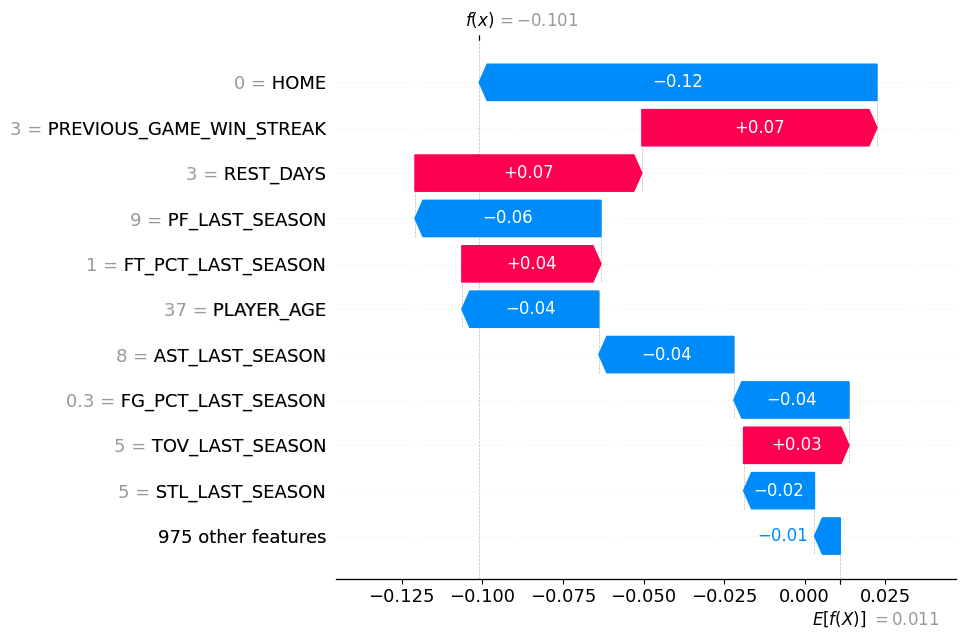

In [53]:
# (4) Train 3 seeds and pick up 1 representative seed result to explain feature to target relationships using shap.
explainer = shap.Explainer(xg_model, X_train)
shap_values = explainer(X_test, check_additivity = False)
# which of the variables are important to the target = bare_nuclei
shap.plots.waterfall(shap_values[0], max_display = 11)

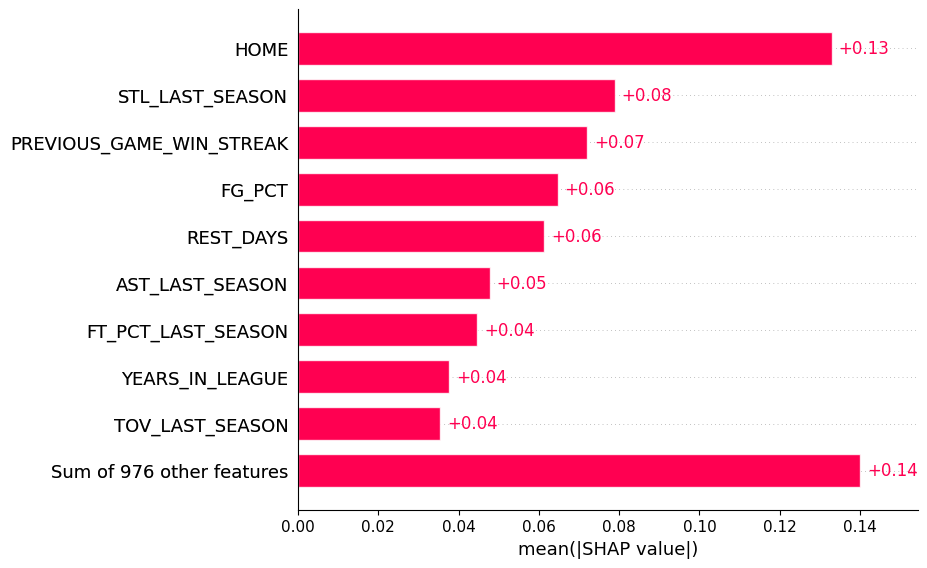

In [54]:
shap.plots.bar(shap_values)

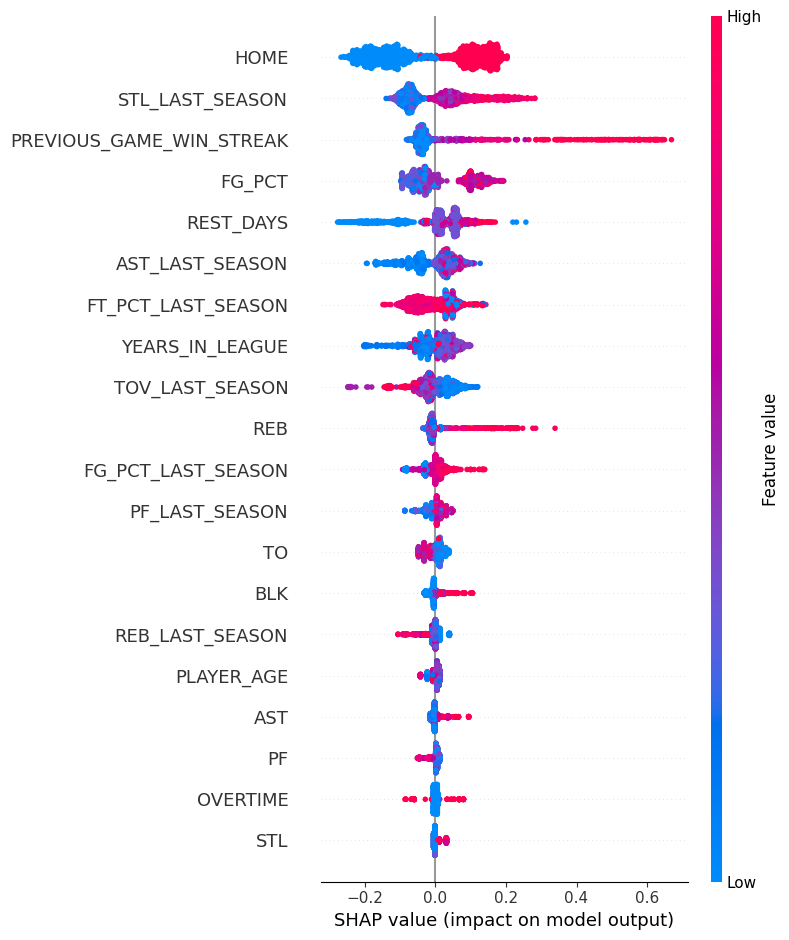

In [55]:
shap.summary_plot(shap_values)

In [59]:
# prompt: use xgboost native api as the model

import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# ... (Your existing code for data loading, preprocessing, and seed generation) ...
seed = random_numbers[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Define objective function for Optuna
def objective(trial):
    # Suggest values for hyperparameters
    params = {
        'objective': 'binary:logistic',  # For binary classification
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3),
        'max_depth': trial.suggest_int("max_depth", 3, 100),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'n_estimators': trial.suggest_int("n_estimators", 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10)
    }

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    model = xgb.train(params, dtrain)

    y_pred_prob = model.predict(dtest)
    y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create study object
study = optuna.create_study(direction="maximize")

# Run optimization process
study.optimize(objective, n_trials=20, show_progress_bar=True)

# Print best trial and best hyperparameters
print("Best trial:", study.best_trial)
print("Best hyperparameters:", study.best_params)


# Train the final XGBoost model with the best hyperparameters
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
xg_model = xgb.train(best_params, dtrain)

y_pred_prob = xg_model.predict(dtest)
y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print(f"F1 Score - Negative: {f1_score(y_test, y_pred, pos_label = 0):.3f}")
print(f"Specificity: {precision_score(y_test, y_pred):.3f}")
print(f"Sensitivity: {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.3f}")
print(confusion_matrix(y_test, y_pred))


[I 2025-02-13 00:11:53,056] A new study created in memory with name: no-name-01a5d022-d591-4139-bf44-4456d264703c


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:11:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:11:59,204] Trial 0 finished with value: 0.6230366492146597 and parameters: {'learning_rate': 0.138775804067772, 'max_depth': 15, 'subsample': 0.8696009311245334, 'colsample_bytree': 0.5967622891128165, 'n_estimators': 449, 'min_child_weight': 3, 'gamma': 2.4800182990385955, 'reg_alpha': 4.844899339227159}. Best is trial 0 with value: 0.6230366492146597.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:12:00,602] Trial 1 finished with value: 0.6230366492146597 and parameters: {'learning_rate': 0.170428754184751, 'max_depth': 86, 'subsample': 0.9798753003800704, 'colsample_bytree': 0.8474033190765591, 'n_estimators': 337, 'min_child_weight': 7, 'gamma': 0.23509828599910465, 'reg_alpha': 9.69295206052694}. Best is trial 0 with value: 0.6230366492146597.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:12:01,787] Trial 2 finished with value: 0.6068062827225131 and parameters: {'learning_rate': 0.26513675223976724, 'max_depth': 65, 'subsample': 0.6962630080955574, 'colsample_bytree': 0.6957160246401519, 'n_estimators': 121, 'min_child_weight': 3, 'gamma': 2.030807979270225, 'reg_alpha': 8.883291759828493}. Best is trial 0 with value: 0.6230366492146597.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:12:02,915] Trial 3 finished with value: 0.6036649214659686 and parameters: {'learning_rate': 0.14478195401305105, 'max_depth': 24, 'subsample': 0.888228673959733, 'colsample_bytree': 0.5892682706941519, 'n_estimators': 278, 'min_child_weight': 8, 'gamma': 8.755425242719864, 'reg_alpha': 8.167638491665306}. Best is trial 0 with value: 0.6230366492146597.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:12:04,068] Trial 4 finished with value: 0.6041884816753926 and parameters: {'learning_rate': 0.2830430563668935, 'max_depth': 68, 'subsample': 0.7105138159376814, 'colsample_bytree': 0.7840290113138775, 'n_estimators': 344, 'min_child_weight': 5, 'gamma': 5.871528458349648, 'reg_alpha': 3.0801172872788882}. Best is trial 0 with value: 0.6230366492146597.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:12:05,282] Trial 5 finished with value: 0.6005235602094241 and parameters: {'learning_rate': 0.12512618052374122, 'max_depth': 8, 'subsample': 0.9728455633737322, 'colsample_bytree': 0.9544054224050516, 'n_estimators': 244, 'min_child_weight': 6, 'gamma': 5.687636207071863, 'reg_alpha': 9.937933337287166}. Best is trial 0 with value: 0.6230366492146597.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:12:06,397] Trial 6 finished with value: 0.5947643979057592 and parameters: {'learning_rate': 0.2578290518301373, 'max_depth': 95, 'subsample': 0.6772617302886406, 'colsample_bytree': 0.7534330600664456, 'n_estimators': 347, 'min_child_weight': 3, 'gamma': 8.683755598889736, 'reg_alpha': 4.778769123266056}. Best is trial 0 with value: 0.6230366492146597.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:12:08,710] Trial 7 finished with value: 0.6020942408376964 and parameters: {'learning_rate': 0.2666913884853916, 'max_depth': 34, 'subsample': 0.7087942351755014, 'colsample_bytree': 0.5031070494935674, 'n_estimators': 295, 'min_child_weight': 4, 'gamma': 7.974776634235258, 'reg_alpha': 5.68842111773622}. Best is trial 0 with value: 0.6230366492146597.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:12:10,273] Trial 8 finished with value: 0.6109947643979058 and parameters: {'learning_rate': 0.019871200690596127, 'max_depth': 63, 'subsample': 0.5471718872082976, 'colsample_bytree': 0.6874245898299983, 'n_estimators': 396, 'min_child_weight': 5, 'gamma': 1.6318129790648894, 'reg_alpha': 2.770225130641719}. Best is trial 0 with value: 0.6230366492146597.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:12:11,413] Trial 9 finished with value: 0.5984293193717277 and parameters: {'learning_rate': 0.03412641737378329, 'max_depth': 59, 'subsample': 0.7135408318006351, 'colsample_bytree': 0.6007203975672281, 'n_estimators': 83, 'min_child_weight': 10, 'gamma': 6.986953095379343, 'reg_alpha': 5.609691663479044}. Best is trial 0 with value: 0.6230366492146597.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:12:12,572] Trial 10 finished with value: 0.5921465968586388 and parameters: {'learning_rate': 0.08529127567359587, 'max_depth': 3, 'subsample': 0.8541654775289904, 'colsample_bytree': 0.5201505729774237, 'n_estimators': 493, 'min_child_weight': 1, 'gamma': 3.3981380159068806, 'reg_alpha': 0.20367422317822914}. Best is trial 0 with value: 0.6230366492146597.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:12:14,008] Trial 11 finished with value: 0.6172774869109947 and parameters: {'learning_rate': 0.19706557522748525, 'max_depth': 99, 'subsample': 0.9923247625652885, 'colsample_bytree': 0.8695991282418873, 'n_estimators': 481, 'min_child_weight': 7, 'gamma': 0.2545247966984389, 'reg_alpha': 6.216515968647207}. Best is trial 0 with value: 0.6230366492146597.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:12:15,296] Trial 12 finished with value: 0.6376963350785341 and parameters: {'learning_rate': 0.19025872868303395, 'max_depth': 42, 'subsample': 0.867608119224238, 'colsample_bytree': 0.8673717804084506, 'n_estimators': 415, 'min_child_weight': 1, 'gamma': 3.7196740303019356, 'reg_alpha': 7.616033458906546}. Best is trial 12 with value: 0.6376963350785341.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:12:18,716] Trial 13 finished with value: 0.6335078534031413 and parameters: {'learning_rate': 0.20948128471536087, 'max_depth': 41, 'subsample': 0.8278865960305963, 'colsample_bytree': 0.9648314929363824, 'n_estimators': 433, 'min_child_weight': 1, 'gamma': 3.845249662243438, 'reg_alpha': 7.506949183158412}. Best is trial 12 with value: 0.6376963350785341.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:12:22,780] Trial 14 finished with value: 0.6094240837696335 and parameters: {'learning_rate': 0.21617556651213263, 'max_depth': 42, 'subsample': 0.8015077426018519, 'colsample_bytree': 0.9830342743900196, 'n_estimators': 417, 'min_child_weight': 1, 'gamma': 4.205718609030036, 'reg_alpha': 7.210603057812532}. Best is trial 12 with value: 0.6376963350785341.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:12:24,829] Trial 15 finished with value: 0.6366492146596858 and parameters: {'learning_rate': 0.2251568356141284, 'max_depth': 40, 'subsample': 0.8210887231537114, 'colsample_bytree': 0.913109426119005, 'n_estimators': 189, 'min_child_weight': 1, 'gamma': 4.537441298547781, 'reg_alpha': 7.5303298521285535}. Best is trial 12 with value: 0.6376963350785341.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:12:26,074] Trial 16 finished with value: 0.6157068062827226 and parameters: {'learning_rate': 0.23169698914233164, 'max_depth': 49, 'subsample': 0.9178788127943514, 'colsample_bytree': 0.8883460815447033, 'n_estimators': 149, 'min_child_weight': 2, 'gamma': 5.047497847564678, 'reg_alpha': 7.144671283394156}. Best is trial 12 with value: 0.6376963350785341.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:12:27,271] Trial 17 finished with value: 0.5947643979057592 and parameters: {'learning_rate': 0.1863386936784579, 'max_depth': 26, 'subsample': 0.7941028149661488, 'colsample_bytree': 0.8128043254580248, 'n_estimators': 204, 'min_child_weight': 2, 'gamma': 9.913979102440855, 'reg_alpha': 8.48489433026797}. Best is trial 12 with value: 0.6376963350785341.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:12:28,738] Trial 18 finished with value: 0.6068062827225131 and parameters: {'learning_rate': 0.10046103758571538, 'max_depth': 78, 'subsample': 0.5645589942814497, 'colsample_bytree': 0.8999367102747668, 'n_estimators': 229, 'min_child_weight': 2, 'gamma': 2.8835806585823214, 'reg_alpha': 3.710256249323632}. Best is trial 12 with value: 0.6376963350785341.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:12:29,902] Trial 19 finished with value: 0.6115183246073298 and parameters: {'learning_rate': 0.24101756330686408, 'max_depth': 51, 'subsample': 0.6205085567306299, 'colsample_bytree': 0.9274217432207863, 'n_estimators': 175, 'min_child_weight': 4, 'gamma': 6.554468712033502, 'reg_alpha': 6.359852474113531}. Best is trial 12 with value: 0.6376963350785341.
Best trial: FrozenTrial(number=12, state=1, values=[0.6376963350785341], datetime_start=datetime.datetime(2025, 2, 13, 0, 12, 14, 18255), datetime_complete=datetime.datetime(2025, 2, 13, 0, 12, 15, 295727), params={'learning_rate': 0.19025872868303395, 'max_depth': 42, 'subsample': 0.867608119224238, 'colsample_bytree': 0.8673717804084506, 'n_estimators': 415, 'min_child_weight': 1, 'gamma': 3.7196740303019356, 'reg_alpha': 7.616033458906546}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistributio

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.638
F1 Score: 0.644
F1 Score - Negative: 0.632
Specificity: 0.633
Sensitivity: 0.654
ROC AUC: 0.638
[[593 362]
 [330 625]]


In [60]:
# prompt: use sklearn to selectmodel the base model is xgboost and use it as feature selection and then xgboost native api as machine learning model

from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier  # Import XGBClassifier

# Use the trained GradientBoostingClassifier for feature selection
selector = SelectFromModel(XGBClassifier(**study.best_params), threshold="median")  # Instantiate XGBClassifier with best params
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Train the final XGBoost model with the selected features using native API
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
dtrain = xgb.DMatrix(X_train_selected, label=y_train)
dtest = xgb.DMatrix(X_test_selected, label=y_test)
xg_model_final = xgb.train(best_params, dtrain)

y_pred_prob = xg_model_final.predict(dtest)
y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

print(f"Accuracy (with feature selection): {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score (with feature selection): {f1_score(y_test, y_pred):.3f}")
print(f"F1 Score - Negative: {f1_score(y_test, y_pred, pos_label = 0):.3f}")
print(f"Specificity (with feature selection): {precision_score(y_test, y_pred):.3f}")
print(f"Sensitivity (with feature selection): {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC (with feature selection): {roc_auc_score(y_test, y_pred):.3f}")
print(confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy (with feature selection): 0.638
F1 Score (with feature selection): 0.644
F1 Score - Negative: 0.632
Specificity (with feature selection): 0.633
Sensitivity (with feature selection): 0.654
ROC AUC (with feature selection): 0.638
[[593 362]
 [330 625]]


In [61]:
explainer = shap.Explainer(xg_model, X_train)
shap_values2 = explainer(X_test, check_additivity = False)

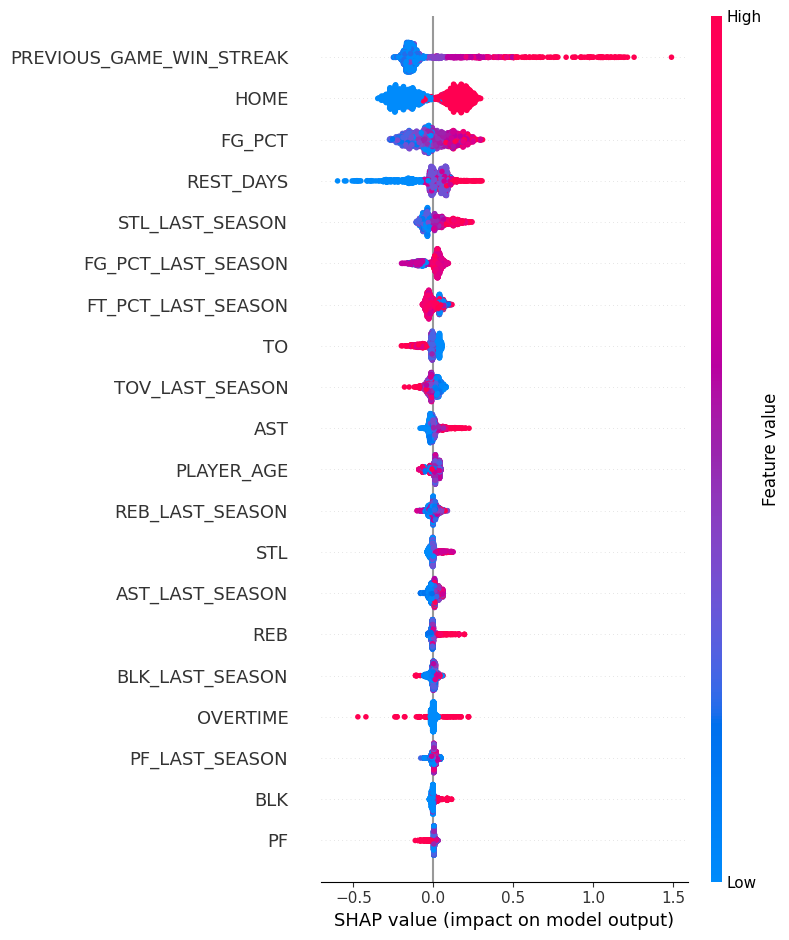

In [75]:
shap.summary_plot(shap_values2)

In [63]:
# prompt: use xgboost native api as the model

import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# ... (Your existing code for data loading, preprocessing, and seed generation) ...
seed = random_numbers[2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Define objective function for Optuna
def objective(trial):
    # Suggest values for hyperparameters
    params = {
        'objective': 'binary:logistic',  # For binary classification
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3),
        'max_depth': trial.suggest_int("max_depth", 3, 100),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'n_estimators': trial.suggest_int("n_estimators", 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10)
    }

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    model = xgb.train(params, dtrain)

    y_pred_prob = model.predict(dtest)
    y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create study object
study = optuna.create_study(direction="maximize")

# Run optimization process
study.optimize(objective, n_trials=20, show_progress_bar=True)

# Print best trial and best hyperparameters
print("Best trial:", study.best_trial)
print("Best hyperparameters:", study.best_params)


# Train the final XGBoost model with the best hyperparameters
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
xg_model = xgb.train(best_params, dtrain)

y_pred_prob = xg_model.predict(dtest)
y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print(f"F1 Score - Negative: {f1_score(y_test, y_pred, pos_label = 0):.3f}")
print(f"Specificity: {precision_score(y_test, y_pred):.3f}")
print(f"Sensitivity: {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.3f}")
print(confusion_matrix(y_test, y_pred))


[I 2025-02-13 00:13:18,069] A new study created in memory with name: no-name-376cb00f-ddff-47f9-b707-215aa14dc188


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:13:22,265] Trial 0 finished with value: 0.6293193717277487 and parameters: {'learning_rate': 0.25833081725444873, 'max_depth': 74, 'subsample': 0.9947063063049828, 'colsample_bytree': 0.8935394415081428, 'n_estimators': 152, 'min_child_weight': 1, 'gamma': 7.3106887575575366, 'reg_alpha': 2.604838313810718}. Best is trial 0 with value: 0.6293193717277487.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:13:23,520] Trial 1 finished with value: 0.6068062827225131 and parameters: {'learning_rate': 0.2891055864955877, 'max_depth': 28, 'subsample': 0.6430698533323549, 'colsample_bytree': 0.6220357968428312, 'n_estimators': 359, 'min_child_weight': 1, 'gamma': 4.275366413523086, 'reg_alpha': 5.522361784993247}. Best is trial 0 with value: 0.6293193717277487.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:13:24,653] Trial 2 finished with value: 0.5790575916230366 and parameters: {'learning_rate': 0.03407396773922151, 'max_depth': 77, 'subsample': 0.6914196704172515, 'colsample_bytree': 0.6132716007500074, 'n_estimators': 298, 'min_child_weight': 6, 'gamma': 7.6572216112988265, 'reg_alpha': 5.639292417610168}. Best is trial 0 with value: 0.6293193717277487.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:13:25,796] Trial 3 finished with value: 0.5853403141361256 and parameters: {'learning_rate': 0.13468127165670596, 'max_depth': 55, 'subsample': 0.5182823048617486, 'colsample_bytree': 0.8589834028112526, 'n_estimators': 390, 'min_child_weight': 7, 'gamma': 4.471232258208442, 'reg_alpha': 9.998750897599656}. Best is trial 0 with value: 0.6293193717277487.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:13:26,911] Trial 4 finished with value: 0.5989528795811518 and parameters: {'learning_rate': 0.19477413240248184, 'max_depth': 63, 'subsample': 0.6853825372830603, 'colsample_bytree': 0.6204303144365408, 'n_estimators': 182, 'min_child_weight': 6, 'gamma': 6.672109355557655, 'reg_alpha': 4.84064992102596}. Best is trial 0 with value: 0.6293193717277487.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:13:28,140] Trial 5 finished with value: 0.5727748691099477 and parameters: {'learning_rate': 0.019619760454878836, 'max_depth': 81, 'subsample': 0.5290426888336979, 'colsample_bytree': 0.9261236042051157, 'n_estimators': 364, 'min_child_weight': 2, 'gamma': 6.654002214814443, 'reg_alpha': 4.147147427747272}. Best is trial 0 with value: 0.6293193717277487.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:13:29,288] Trial 6 finished with value: 0.5921465968586388 and parameters: {'learning_rate': 0.13866139306451303, 'max_depth': 96, 'subsample': 0.8059407882822852, 'colsample_bytree': 0.7497044231677614, 'n_estimators': 57, 'min_child_weight': 2, 'gamma': 5.837523900792787, 'reg_alpha': 6.383813293259827}. Best is trial 0 with value: 0.6293193717277487.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:13:30,445] Trial 7 finished with value: 0.5785340314136126 and parameters: {'learning_rate': 0.11169192634357397, 'max_depth': 18, 'subsample': 0.7342432424012157, 'colsample_bytree': 0.6225724164375779, 'n_estimators': 410, 'min_child_weight': 7, 'gamma': 7.66282628630052, 'reg_alpha': 8.958355930019353}. Best is trial 0 with value: 0.6293193717277487.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:13:33,148] Trial 8 finished with value: 0.587434554973822 and parameters: {'learning_rate': 0.08043272755387426, 'max_depth': 67, 'subsample': 0.7086769794548932, 'colsample_bytree': 0.5448083339100666, 'n_estimators': 454, 'min_child_weight': 4, 'gamma': 1.728586245795427, 'reg_alpha': 4.3188577043223875}. Best is trial 0 with value: 0.6293193717277487.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:13:35,522] Trial 9 finished with value: 0.587958115183246 and parameters: {'learning_rate': 0.12845916633846344, 'max_depth': 65, 'subsample': 0.7402630325291122, 'colsample_bytree': 0.5919865447592066, 'n_estimators': 101, 'min_child_weight': 4, 'gamma': 7.6386733392907935, 'reg_alpha': 1.608073426228962}. Best is trial 0 with value: 0.6293193717277487.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:13:36,681] Trial 10 finished with value: 0.5968586387434555 and parameters: {'learning_rate': 0.29475751267380734, 'max_depth': 40, 'subsample': 0.988839508745744, 'colsample_bytree': 0.995177362712053, 'n_estimators': 183, 'min_child_weight': 10, 'gamma': 9.482532892828317, 'reg_alpha': 0.2578033307988363}. Best is trial 0 with value: 0.6293193717277487.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:13:37,985] Trial 11 finished with value: 0.6565445026178011 and parameters: {'learning_rate': 0.29444168926119607, 'max_depth': 33, 'subsample': 0.9951739168754463, 'colsample_bytree': 0.7699097636532214, 'n_estimators': 251, 'min_child_weight': 1, 'gamma': 3.6437555086361275, 'reg_alpha': 2.576027386237068}. Best is trial 11 with value: 0.6565445026178011.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:13:40,340] Trial 12 finished with value: 0.5827225130890052 and parameters: {'learning_rate': 0.22655045022875514, 'max_depth': 3, 'subsample': 0.9963966265933665, 'colsample_bytree': 0.791916367947529, 'n_estimators': 217, 'min_child_weight': 1, 'gamma': 1.395686214418017, 'reg_alpha': 2.377714732881864}. Best is trial 11 with value: 0.6565445026178011.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:13:41,872] Trial 13 finished with value: 0.6151832460732984 and parameters: {'learning_rate': 0.24561986840377964, 'max_depth': 40, 'subsample': 0.8897643103538646, 'colsample_bytree': 0.7355370715433446, 'n_estimators': 254, 'min_child_weight': 3, 'gamma': 2.85877878516256, 'reg_alpha': 2.5260633385424724}. Best is trial 11 with value: 0.6565445026178011.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:13:43,102] Trial 14 finished with value: 0.6052356020942409 and parameters: {'learning_rate': 0.2534722520359097, 'max_depth': 96, 'subsample': 0.9057528009315201, 'colsample_bytree': 0.8382451917887271, 'n_estimators': 137, 'min_child_weight': 4, 'gamma': 9.279219312741056, 'reg_alpha': 0.9025109629406511}. Best is trial 11 with value: 0.6565445026178011.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:13:44,368] Trial 15 finished with value: 0.6083769633507854 and parameters: {'learning_rate': 0.18497801834751731, 'max_depth': 43, 'subsample': 0.9181652829794325, 'colsample_bytree': 0.7071102621369892, 'n_estimators': 283, 'min_child_weight': 10, 'gamma': 3.2424940585413267, 'reg_alpha': 3.341886194167212}. Best is trial 11 with value: 0.6565445026178011.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:13:45,787] Trial 16 finished with value: 0.6005235602094241 and parameters: {'learning_rate': 0.26575318961340133, 'max_depth': 22, 'subsample': 0.8354452258497134, 'colsample_bytree': 0.9076064153143499, 'n_estimators': 142, 'min_child_weight': 1, 'gamma': 5.359509352040883, 'reg_alpha': 7.253159868502288}. Best is trial 11 with value: 0.6565445026178011.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:13:48,288] Trial 17 finished with value: 0.587434554973822 and parameters: {'learning_rate': 0.19274489659538097, 'max_depth': 82, 'subsample': 0.9530738738114279, 'colsample_bytree': 0.6865536828411759, 'n_estimators': 233, 'min_child_weight': 3, 'gamma': 0.2691781235207449, 'reg_alpha': 3.2078175394692003}. Best is trial 11 with value: 0.6565445026178011.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:13:49,564] Trial 18 finished with value: 0.6345549738219896 and parameters: {'learning_rate': 0.23478102813410512, 'max_depth': 53, 'subsample': 0.8369780065892642, 'colsample_bytree': 0.8088260805498098, 'n_estimators': 298, 'min_child_weight': 2, 'gamma': 3.3774861348752094, 'reg_alpha': 1.670529890718629}. Best is trial 11 with value: 0.6565445026178011.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:13:50,847] Trial 19 finished with value: 0.6052356020942409 and parameters: {'learning_rate': 0.22524591171166222, 'max_depth': 51, 'subsample': 0.8354432163399632, 'colsample_bytree': 0.8150584111717156, 'n_estimators': 307, 'min_child_weight': 3, 'gamma': 3.0327329512995598, 'reg_alpha': 1.4201524184061394}. Best is trial 11 with value: 0.6565445026178011.
Best trial: FrozenTrial(number=11, state=1, values=[0.6565445026178011], datetime_start=datetime.datetime(2025, 2, 13, 0, 13, 36, 686539), datetime_complete=datetime.datetime(2025, 2, 13, 0, 13, 37, 985013), params={'learning_rate': 0.29444168926119607, 'max_depth': 33, 'subsample': 0.9951739168754463, 'colsample_bytree': 0.7699097636532214, 'n_estimators': 251, 'min_child_weight': 1, 'gamma': 3.6437555086361275, 'reg_alpha': 2.576027386237068}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistrib

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.657
F1 Score: 0.658
F1 Score - Negative: 0.655
Specificity: 0.641
Sensitivity: 0.676
ROC AUC: 0.657
[[623 354]
 [302 631]]


In [64]:
# prompt: use sklearn to selectmodel the base model is xgboost and use it as feature selection and then xgboost native api as machine learning model

from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier  # Import XGBClassifier

# Use the trained GradientBoostingClassifier for feature selection
selector = SelectFromModel(XGBClassifier(**study.best_params), threshold="median")  # Instantiate XGBClassifier with best params
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Train the final XGBoost model with the selected features using native API
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
dtrain = xgb.DMatrix(X_train_selected, label=y_train)
dtest = xgb.DMatrix(X_test_selected, label=y_test)
xg_model_final = xgb.train(best_params, dtrain)

y_pred_prob = xg_model_final.predict(dtest)
y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

print(f"Accuracy (with feature selection): {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score (with feature selection): {f1_score(y_test, y_pred):.3f}")
print(f"F1 Score - Negative: {f1_score(y_test, y_pred, pos_label = 0):.3f}")
print(f"Specificity (with feature selection): {precision_score(y_test, y_pred):.3f}")
print(f"Sensitivity (with feature selection): {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC (with feature selection): {roc_auc_score(y_test, y_pred):.3f}")
print(confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:14:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy (with feature selection): 0.657
F1 Score (with feature selection): 0.658
F1 Score - Negative: 0.655
Specificity (with feature selection): 0.641
Sensitivity (with feature selection): 0.676
ROC AUC (with feature selection): 0.657
[[623 354]
 [302 631]]


In [65]:
explainer = shap.Explainer(xg_model, X_train)
shap_values3 = explainer(X_test, check_additivity = False)

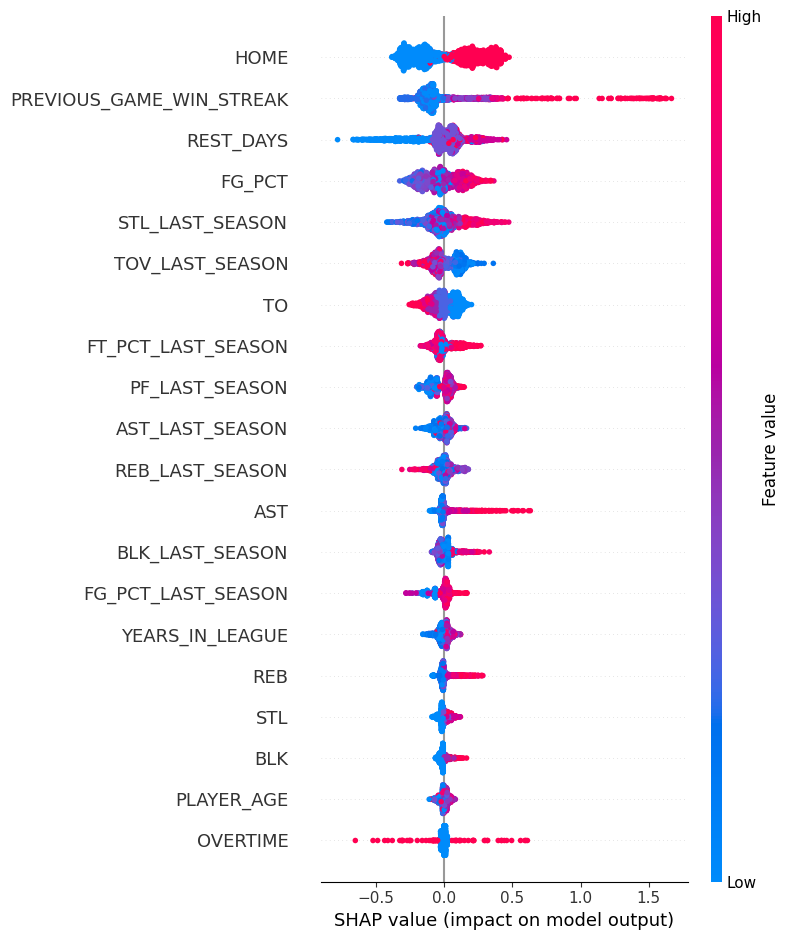

In [76]:
shap.summary_plot(shap_values3)

In [69]:
# prompt: use xgboost native api as the model

import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# ... (Your existing code for data loading, preprocessing, and seed generation) ...
seed = random_numbers[3]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Define objective function for Optuna
def objective(trial):
    # Suggest values for hyperparameters
    params = {
        'objective': 'binary:logistic',  # For binary classification
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3),
        'max_depth': trial.suggest_int("max_depth", 3, 100),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'n_estimators': trial.suggest_int("n_estimators", 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10)
    }

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    model = xgb.train(params, dtrain)

    y_pred_prob = model.predict(dtest)
    y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create study object
study = optuna.create_study(direction="maximize")

# Run optimization process
study.optimize(objective, n_trials=20, show_progress_bar=True)

# Print best trial and best hyperparameters
print("Best trial:", study.best_trial)
print("Best hyperparameters:", study.best_params)


# Train the final XGBoost model with the best hyperparameters
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
xg_model = xgb.train(best_params, dtrain)

y_pred_prob = xg_model.predict(dtest)
y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print(f"F1 Score - Negative: {f1_score(y_test, y_pred, pos_label = 0):.3f}")
print(f"Specificity: {precision_score(y_test, y_pred):.3f}")
print(f"Sensitivity: {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.3f}")
print(confusion_matrix(y_test, y_pred))

[I 2025-02-13 00:16:40,909] A new study created in memory with name: no-name-9d14fd3f-1307-404b-8bf7-452a21c8d94c


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:16:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:16:42,363] Trial 0 finished with value: 0.6115183246073298 and parameters: {'learning_rate': 0.11487270795690546, 'max_depth': 5, 'subsample': 0.6924316115121247, 'colsample_bytree': 0.9919514997635565, 'n_estimators': 441, 'min_child_weight': 1, 'gamma': 1.6064597205921016, 'reg_alpha': 2.937493153934759}. Best is trial 0 with value: 0.6115183246073298.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:16:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:16:43,480] Trial 1 finished with value: 0.5984293193717277 and parameters: {'learning_rate': 0.252729524990471, 'max_depth': 3, 'subsample': 0.5727828138865243, 'colsample_bytree': 0.9875840947136583, 'n_estimators': 69, 'min_child_weight': 1, 'gamma': 3.3929096649687853, 'reg_alpha': 0.570431127867238}. Best is trial 0 with value: 0.6115183246073298.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:16:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:16:44,613] Trial 2 finished with value: 0.6031413612565445 and parameters: {'learning_rate': 0.11860998283496085, 'max_depth': 77, 'subsample': 0.7177561411245751, 'colsample_bytree': 0.8585408123912979, 'n_estimators': 118, 'min_child_weight': 3, 'gamma': 7.999563156164599, 'reg_alpha': 5.093881326167711}. Best is trial 0 with value: 0.6115183246073298.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:16:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:16:47,223] Trial 3 finished with value: 0.6157068062827226 and parameters: {'learning_rate': 0.2559889101884335, 'max_depth': 86, 'subsample': 0.5959453755519002, 'colsample_bytree': 0.949872532389703, 'n_estimators': 369, 'min_child_weight': 5, 'gamma': 2.3553383286748875, 'reg_alpha': 7.420575665663405}. Best is trial 3 with value: 0.6157068062827226.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:16:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:16:48,577] Trial 4 finished with value: 0.5921465968586388 and parameters: {'learning_rate': 0.21106086133612317, 'max_depth': 64, 'subsample': 0.5553312628320188, 'colsample_bytree': 0.6698232663617814, 'n_estimators': 493, 'min_child_weight': 1, 'gamma': 6.904166556222307, 'reg_alpha': 5.2715868427671095}. Best is trial 3 with value: 0.6157068062827226.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:16:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:16:49,671] Trial 5 finished with value: 0.6214659685863875 and parameters: {'learning_rate': 0.2738858972031895, 'max_depth': 48, 'subsample': 0.9425656753618669, 'colsample_bytree': 0.9169712123755629, 'n_estimators': 74, 'min_child_weight': 7, 'gamma': 9.7982463522132, 'reg_alpha': 3.2029609383413216}. Best is trial 5 with value: 0.6214659685863875.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:16:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:16:50,876] Trial 6 finished with value: 0.6162303664921466 and parameters: {'learning_rate': 0.11391491180437777, 'max_depth': 79, 'subsample': 0.6490668331882699, 'colsample_bytree': 0.6417415101225515, 'n_estimators': 223, 'min_child_weight': 8, 'gamma': 2.77682698003567, 'reg_alpha': 1.8140277114055225}. Best is trial 5 with value: 0.6214659685863875.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:16:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:16:51,989] Trial 7 finished with value: 0.6020942408376964 and parameters: {'learning_rate': 0.2311973396601868, 'max_depth': 87, 'subsample': 0.8546928338756394, 'colsample_bytree': 0.5587532606625001, 'n_estimators': 318, 'min_child_weight': 8, 'gamma': 9.867509671445116, 'reg_alpha': 0.3501461399869721}. Best is trial 5 with value: 0.6214659685863875.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:16:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:16:53,238] Trial 8 finished with value: 0.6256544502617801 and parameters: {'learning_rate': 0.15376119497385488, 'max_depth': 23, 'subsample': 0.8403007856183703, 'colsample_bytree': 0.8778158464695909, 'n_estimators': 486, 'min_child_weight': 2, 'gamma': 0.9827167608802856, 'reg_alpha': 8.175427746485557}. Best is trial 8 with value: 0.6256544502617801.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:16:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:16:54,468] Trial 9 finished with value: 0.6115183246073298 and parameters: {'learning_rate': 0.2803141588213244, 'max_depth': 54, 'subsample': 0.9500763211620726, 'colsample_bytree': 0.7026352242054359, 'n_estimators': 496, 'min_child_weight': 5, 'gamma': 3.0569160528961534, 'reg_alpha': 0.3090196834395209}. Best is trial 8 with value: 0.6256544502617801.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:16:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:16:55,749] Trial 10 finished with value: 0.599476439790576 and parameters: {'learning_rate': 0.020064563760727433, 'max_depth': 30, 'subsample': 0.8329355504850354, 'colsample_bytree': 0.806881593769703, 'n_estimators': 218, 'min_child_weight': 10, 'gamma': 0.09716641856316133, 'reg_alpha': 9.70952144587914}. Best is trial 8 with value: 0.6256544502617801.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:16:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:16:56,926] Trial 11 finished with value: 0.6120418848167539 and parameters: {'learning_rate': 0.1755279190645746, 'max_depth': 33, 'subsample': 0.9666055960980908, 'colsample_bytree': 0.8414786713442822, 'n_estimators': 155, 'min_child_weight': 7, 'gamma': 5.511405874444185, 'reg_alpha': 7.269029625683278}. Best is trial 8 with value: 0.6256544502617801.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:16:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:16:59,371] Trial 12 finished with value: 0.6104712041884817 and parameters: {'learning_rate': 0.18489498576796531, 'max_depth': 32, 'subsample': 0.8334309157625351, 'colsample_bytree': 0.9141482498841231, 'n_estimators': 368, 'min_child_weight': 3, 'gamma': 9.807476438098377, 'reg_alpha': 2.896108655024901}. Best is trial 8 with value: 0.6256544502617801.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:17:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:17:00,856] Trial 13 finished with value: 0.5869109947643979 and parameters: {'learning_rate': 0.0567743712590951, 'max_depth': 19, 'subsample': 0.902657235063125, 'colsample_bytree': 0.7714209843416442, 'n_estimators': 256, 'min_child_weight': 3, 'gamma': 5.408101804647614, 'reg_alpha': 9.954835973407237}. Best is trial 8 with value: 0.6256544502617801.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:17:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:17:01,972] Trial 14 finished with value: 0.6036649214659686 and parameters: {'learning_rate': 0.29914894382910817, 'max_depth': 45, 'subsample': 0.7836550010541234, 'colsample_bytree': 0.8915384366724052, 'n_estimators': 50, 'min_child_weight': 6, 'gamma': 7.4776362536482734, 'reg_alpha': 7.201385804606888}. Best is trial 8 with value: 0.6256544502617801.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:17:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:17:03,345] Trial 15 finished with value: 0.6172774869109947 and parameters: {'learning_rate': 0.1498675491377724, 'max_depth': 100, 'subsample': 0.9930069694195226, 'colsample_bytree': 0.7511256518529406, 'n_estimators': 161, 'min_child_weight': 4, 'gamma': 0.15840484590196802, 'reg_alpha': 4.181686302046785}. Best is trial 8 with value: 0.6256544502617801.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:17:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:17:04,549] Trial 16 finished with value: 0.6157068062827226 and parameters: {'learning_rate': 0.08470558066146183, 'max_depth': 53, 'subsample': 0.9007875401962859, 'colsample_bytree': 0.9164254325994066, 'n_estimators': 315, 'min_child_weight': 8, 'gamma': 4.28993465950054, 'reg_alpha': 8.51905745033794}. Best is trial 8 with value: 0.6256544502617801.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:17:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:17:05,711] Trial 17 finished with value: 0.5958115183246073 and parameters: {'learning_rate': 0.20875115965514301, 'max_depth': 18, 'subsample': 0.7855766503474997, 'colsample_bytree': 0.8295293007064694, 'n_estimators': 402, 'min_child_weight': 9, 'gamma': 6.6111087859354996, 'reg_alpha': 6.358990534583155}. Best is trial 8 with value: 0.6256544502617801.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:17:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:17:06,872] Trial 18 finished with value: 0.5895287958115183 and parameters: {'learning_rate': 0.15116230069606762, 'max_depth': 43, 'subsample': 0.9031036342553509, 'colsample_bytree': 0.5154555410126945, 'n_estimators': 301, 'min_child_weight': 6, 'gamma': 8.508215255908627, 'reg_alpha': 4.087800041006654}. Best is trial 8 with value: 0.6256544502617801.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:17:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:17:08,090] Trial 19 finished with value: 0.6198952879581152 and parameters: {'learning_rate': 0.1937890071251858, 'max_depth': 64, 'subsample': 0.7688400554860733, 'colsample_bytree': 0.8862622066560515, 'n_estimators': 111, 'min_child_weight': 2, 'gamma': 4.230420968621426, 'reg_alpha': 6.190635246160476}. Best is trial 8 with value: 0.6256544502617801.
Best trial: FrozenTrial(number=8, state=1, values=[0.6256544502617801], datetime_start=datetime.datetime(2025, 2, 13, 0, 16, 51, 995319), datetime_complete=datetime.datetime(2025, 2, 13, 0, 16, 53, 237474), params={'learning_rate': 0.15376119497385488, 'max_depth': 23, 'subsample': 0.8403007856183703, 'colsample_bytree': 0.8778158464695909, 'n_estimators': 486, 'min_child_weight': 2, 'gamma': 0.9827167608802856, 'reg_alpha': 8.175427746485557}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:17:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.626
F1 Score: 0.632
F1 Score - Negative: 0.619
Specificity: 0.644
Sensitivity: 0.620
ROC AUC: 0.626
[[582 339]
 [376 613]]


In [70]:
# prompt: use sklearn to selectmodel the base model is xgboost and use it as feature selection and then xgboost native api as machine learning model

from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier  # Import XGBClassifier

# Use the trained GradientBoostingClassifier for feature selection
selector = SelectFromModel(XGBClassifier(**study.best_params), threshold="median")  # Instantiate XGBClassifier with best params
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Train the final XGBoost model with the selected features using native API
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
dtrain = xgb.DMatrix(X_train_selected, label=y_train)
dtest = xgb.DMatrix(X_test_selected, label=y_test)
xg_model_final = xgb.train(best_params, dtrain)

y_pred_prob = xg_model_final.predict(dtest)
y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

print(f"Accuracy (with feature selection): {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score (with feature selection): {f1_score(y_test, y_pred):.3f}")
print(f"F1 Score - Negative: {f1_score(y_test, y_pred, pos_label = 0):.3f}")
print(f"Specificity (with feature selection): {precision_score(y_test, y_pred):.3f}")
print(f"Sensitivity (with feature selection): {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC (with feature selection): {roc_auc_score(y_test, y_pred):.3f}")
print(confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:17:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy (with feature selection): 0.626
F1 Score (with feature selection): 0.632
F1 Score - Negative: 0.619
Specificity (with feature selection): 0.644
Sensitivity (with feature selection): 0.620
ROC AUC (with feature selection): 0.626
[[582 339]
 [376 613]]


In [71]:
explainer = shap.Explainer(xg_model, X_train)
shap_values4 = explainer(X_test, check_additivity = False)

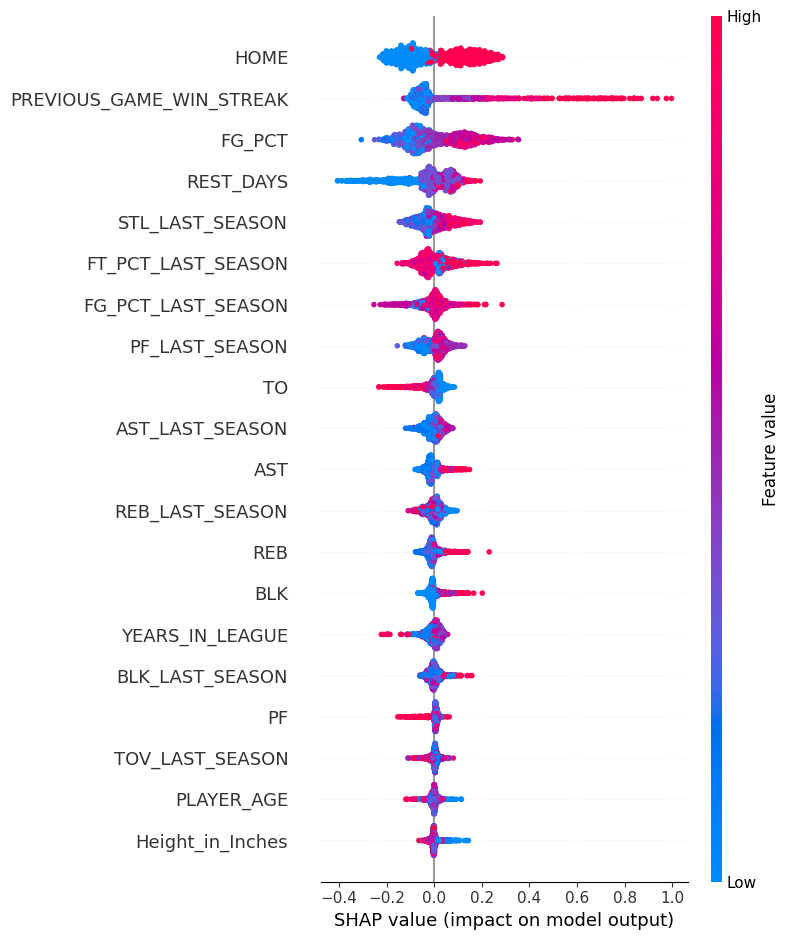

In [77]:
shap.summary_plot(shap_values4)

In [72]:
# prompt: use xgboost native api as the model

import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# ... (Your existing code for data loading, preprocessing, and seed generation) ...
seed = random_numbers[4]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Define objective function for Optuna
def objective(trial):
    # Suggest values for hyperparameters
    params = {
        'objective': 'binary:logistic',  # For binary classification
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3),
        'max_depth': trial.suggest_int("max_depth", 3, 100),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'n_estimators': trial.suggest_int("n_estimators", 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10)
    }

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    model = xgb.train(params, dtrain)

    y_pred_prob = model.predict(dtest)
    y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create study object
study = optuna.create_study(direction="maximize")

# Run optimization process
study.optimize(objective, n_trials=20, show_progress_bar=True)

# Print best trial and best hyperparameters
print("Best trial:", study.best_trial)
print("Best hyperparameters:", study.best_params)


# Train the final XGBoost model with the best hyperparameters
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
xg_model = xgb.train(best_params, dtrain)

y_pred_prob = xg_model.predict(dtest)
y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print(f"F1 Score - Negative: {f1_score(y_test, y_pred, pos_label = 0):.3f}")
print(f"Specificity: {precision_score(y_test, y_pred):.3f}")
print(f"Sensitivity: {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.3f}")
print(confusion_matrix(y_test, y_pred))

[I 2025-02-13 00:18:20,173] A new study created in memory with name: no-name-ac0d44ee-1f55-4f26-9ede-96086a58b78b


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:18:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:18:24,201] Trial 0 finished with value: 0.5979057591623037 and parameters: {'learning_rate': 0.01765037511817414, 'max_depth': 62, 'subsample': 0.8661590884198216, 'colsample_bytree': 0.9760602641228096, 'n_estimators': 167, 'min_child_weight': 8, 'gamma': 1.254826070644931, 'reg_alpha': 0.4939127783885733}. Best is trial 0 with value: 0.5979057591623037.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:18:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:18:25,325] Trial 1 finished with value: 0.581151832460733 and parameters: {'learning_rate': 0.14573642399727643, 'max_depth': 52, 'subsample': 0.8424406382849244, 'colsample_bytree': 0.8778194337122283, 'n_estimators': 158, 'min_child_weight': 1, 'gamma': 9.845560826115673, 'reg_alpha': 9.299562366681961}. Best is trial 0 with value: 0.5979057591623037.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:18:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:18:26,465] Trial 2 finished with value: 0.5732984293193717 and parameters: {'learning_rate': 0.13446349226567034, 'max_depth': 6, 'subsample': 0.6131614348067553, 'colsample_bytree': 0.8423799756972171, 'n_estimators': 328, 'min_child_weight': 8, 'gamma': 8.036193362123651, 'reg_alpha': 9.908228568973117}. Best is trial 0 with value: 0.5979057591623037.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:18:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:18:27,636] Trial 3 finished with value: 0.5816753926701571 and parameters: {'learning_rate': 0.19639127540872486, 'max_depth': 30, 'subsample': 0.7291934364102625, 'colsample_bytree': 0.7229317264292134, 'n_estimators': 407, 'min_child_weight': 6, 'gamma': 8.692333699855501, 'reg_alpha': 6.711559123240872}. Best is trial 0 with value: 0.5979057591623037.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:18:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:18:28,788] Trial 4 finished with value: 0.5774869109947643 and parameters: {'learning_rate': 0.041629756131012725, 'max_depth': 73, 'subsample': 0.7723358979683477, 'colsample_bytree': 0.7334477903065317, 'n_estimators': 201, 'min_child_weight': 8, 'gamma': 9.693037891185046, 'reg_alpha': 6.191007300782473}. Best is trial 0 with value: 0.5979057591623037.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:18:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:18:29,930] Trial 5 finished with value: 0.5774869109947643 and parameters: {'learning_rate': 0.039321781921540254, 'max_depth': 4, 'subsample': 0.5636871009579725, 'colsample_bytree': 0.5030347912433166, 'n_estimators': 103, 'min_child_weight': 5, 'gamma': 6.581960265309911, 'reg_alpha': 2.9420329703567694}. Best is trial 0 with value: 0.5979057591623037.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:18:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:18:31,061] Trial 6 finished with value: 0.5947643979057592 and parameters: {'learning_rate': 0.284678581801708, 'max_depth': 75, 'subsample': 0.9485221003150566, 'colsample_bytree': 0.9616336700437971, 'n_estimators': 450, 'min_child_weight': 10, 'gamma': 9.299761632863548, 'reg_alpha': 2.389389116902981}. Best is trial 0 with value: 0.5979057591623037.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:18:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:18:32,236] Trial 7 finished with value: 0.5916230366492147 and parameters: {'learning_rate': 0.0162163395972696, 'max_depth': 100, 'subsample': 0.8880695477028995, 'colsample_bytree': 0.6004175081311192, 'n_estimators': 90, 'min_child_weight': 8, 'gamma': 5.050183406895168, 'reg_alpha': 6.502577130784638}. Best is trial 0 with value: 0.5979057591623037.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:18:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:18:33,450] Trial 8 finished with value: 0.5780104712041885 and parameters: {'learning_rate': 0.07367325848270607, 'max_depth': 92, 'subsample': 0.5887702743246358, 'colsample_bytree': 0.9139857716755309, 'n_estimators': 165, 'min_child_weight': 5, 'gamma': 4.240437296636138, 'reg_alpha': 9.71218925370303}. Best is trial 0 with value: 0.5979057591623037.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:18:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:18:35,980] Trial 9 finished with value: 0.6120418848167539 and parameters: {'learning_rate': 0.17021037416218085, 'max_depth': 16, 'subsample': 0.9152093903932943, 'colsample_bytree': 0.5958985695567023, 'n_estimators': 425, 'min_child_weight': 7, 'gamma': 4.976471908202104, 'reg_alpha': 2.859045080124636}. Best is trial 9 with value: 0.6120418848167539.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:18:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:18:37,277] Trial 10 finished with value: 0.6486910994764398 and parameters: {'learning_rate': 0.22754847298147995, 'max_depth': 30, 'subsample': 0.961353467852079, 'colsample_bytree': 0.6026474987371254, 'n_estimators': 332, 'min_child_weight': 1, 'gamma': 1.7814208547199688, 'reg_alpha': 3.9086079753888905}. Best is trial 10 with value: 0.6486910994764398.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:18:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:18:38,714] Trial 11 finished with value: 0.6146596858638743 and parameters: {'learning_rate': 0.22607240780937343, 'max_depth': 28, 'subsample': 0.9808838956823251, 'colsample_bytree': 0.6172619282510785, 'n_estimators': 336, 'min_child_weight': 2, 'gamma': 0.5313270120201574, 'reg_alpha': 3.8818868505801034}. Best is trial 10 with value: 0.6486910994764398.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:18:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:18:40,218] Trial 12 finished with value: 0.643979057591623 and parameters: {'learning_rate': 0.2508023453110192, 'max_depth': 36, 'subsample': 0.9995374254890212, 'colsample_bytree': 0.6341252782203249, 'n_estimators': 306, 'min_child_weight': 1, 'gamma': 0.10011813386579882, 'reg_alpha': 4.494965392690417}. Best is trial 10 with value: 0.6486910994764398.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:18:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:18:41,503] Trial 13 finished with value: 0.6277486910994764 and parameters: {'learning_rate': 0.27313077082989984, 'max_depth': 38, 'subsample': 0.9995184802845178, 'colsample_bytree': 0.6695013197679804, 'n_estimators': 268, 'min_child_weight': 3, 'gamma': 2.3161233535381998, 'reg_alpha': 4.824682479526177}. Best is trial 10 with value: 0.6486910994764398.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:18:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:18:42,795] Trial 14 finished with value: 0.5984293193717277 and parameters: {'learning_rate': 0.23980823825841285, 'max_depth': 45, 'subsample': 0.7895476639988587, 'colsample_bytree': 0.5183533360089498, 'n_estimators': 281, 'min_child_weight': 3, 'gamma': 2.532731665827303, 'reg_alpha': 1.2301918694773892}. Best is trial 10 with value: 0.6486910994764398.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:18:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:18:44,191] Trial 15 finished with value: 0.6073298429319371 and parameters: {'learning_rate': 0.23993364931212563, 'max_depth': 19, 'subsample': 0.6919477830343087, 'colsample_bytree': 0.7991967908165908, 'n_estimators': 361, 'min_child_weight': 1, 'gamma': 0.25032842624434615, 'reg_alpha': 4.720700546903169}. Best is trial 10 with value: 0.6486910994764398.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:18:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:18:45,415] Trial 16 finished with value: 0.6178010471204188 and parameters: {'learning_rate': 0.29814643239522703, 'max_depth': 56, 'subsample': 0.9428524801200183, 'colsample_bytree': 0.6764230206328969, 'n_estimators': 491, 'min_child_weight': 3, 'gamma': 2.2465889243190738, 'reg_alpha': 7.762083169288041}. Best is trial 10 with value: 0.6486910994764398.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:18:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:18:48,275] Trial 17 finished with value: 0.6109947643979058 and parameters: {'learning_rate': 0.20104322485445145, 'max_depth': 38, 'subsample': 0.8390914203679922, 'colsample_bytree': 0.5533267671259487, 'n_estimators': 241, 'min_child_weight': 4, 'gamma': 3.536015534085293, 'reg_alpha': 3.9816355749637715}. Best is trial 10 with value: 0.6486910994764398.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:18:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:18:49,649] Trial 18 finished with value: 0.624607329842932 and parameters: {'learning_rate': 0.2624330495593536, 'max_depth': 21, 'subsample': 0.6715090186609776, 'colsample_bytree': 0.6624336719024494, 'n_estimators': 368, 'min_child_weight': 1, 'gamma': 1.30416149588177, 'reg_alpha': 1.7257989483179221}. Best is trial 10 with value: 0.6486910994764398.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:18:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-13 00:18:51,073] Trial 19 finished with value: 0.6 and parameters: {'learning_rate': 0.10360308152389967, 'max_depth': 42, 'subsample': 0.9980602967063359, 'colsample_bytree': 0.7892046029062779, 'n_estimators': 290, 'min_child_weight': 2, 'gamma': 0.09020777502050856, 'reg_alpha': 5.629704831986201}. Best is trial 10 with value: 0.6486910994764398.
Best trial: FrozenTrial(number=10, state=1, values=[0.6486910994764398], datetime_start=datetime.datetime(2025, 2, 13, 0, 18, 35, 986594), datetime_complete=datetime.datetime(2025, 2, 13, 0, 18, 37, 277178), params={'learning_rate': 0.22754847298147995, 'max_depth': 30, 'subsample': 0.961353467852079, 'colsample_bytree': 0.6026474987371254, 'n_estimators': 332, 'min_child_weight': 1, 'gamma': 1.7814208547199688, 'reg_alpha': 3.9086079753888905}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=100,

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:18:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.649
F1 Score: 0.658
F1 Score - Negative: 0.639
Specificity: 0.672
Sensitivity: 0.644
ROC AUC: 0.649
[[594 315]
 [356 645]]


In [73]:
# prompt: use sklearn to selectmodel the base model is xgboost and use it as feature selection and then xgboost native api as machine learning model

from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier  # Import XGBClassifier

# Use the trained GradientBoostingClassifier for feature selection
selector = SelectFromModel(XGBClassifier(**study.best_params), threshold="median")  # Instantiate XGBClassifier with best params
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Train the final XGBoost model with the selected features using native API
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
dtrain = xgb.DMatrix(X_train_selected, label=y_train)
dtest = xgb.DMatrix(X_test_selected, label=y_test)
xg_model_final = xgb.train(best_params, dtrain)

y_pred_prob = xg_model_final.predict(dtest)
y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

print(f"Accuracy (with feature selection): {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score (with feature selection): {f1_score(y_test, y_pred):.3f}")
print(f"F1 Score - Negative: {f1_score(y_test, y_pred, pos_label = 0):.3f}")
print(f"Specificity (with feature selection): {precision_score(y_test, y_pred):.3f}")
print(f"Sensitivity (with feature selection): {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC (with feature selection): {roc_auc_score(y_test, y_pred):.3f}")
print(confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:19:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy (with feature selection): 0.649
F1 Score (with feature selection): 0.658
F1 Score - Negative: 0.639
Specificity (with feature selection): 0.672
Sensitivity (with feature selection): 0.644
ROC AUC (with feature selection): 0.649
[[594 315]
 [356 645]]


In [74]:
explainer = shap.Explainer(xg_model, X_train)
shap_values5 = explainer(X_test, check_additivity = False)

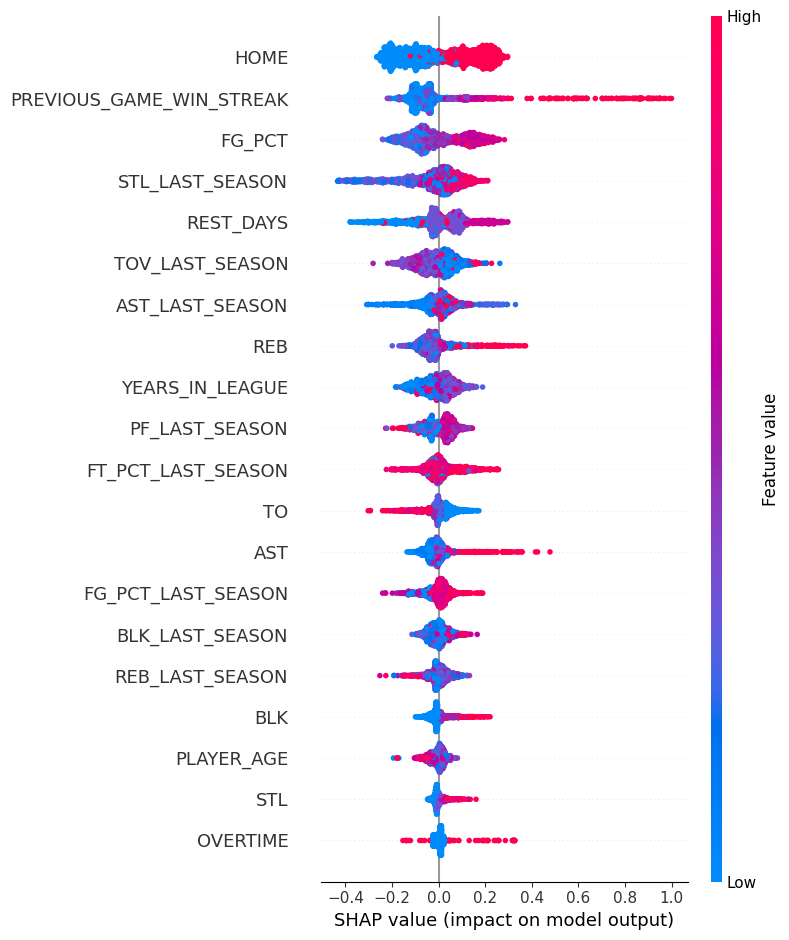

In [78]:
shap.summary_plot(shap_values5)